<a href="https://colab.research.google.com/github/bigCow13/Study/blob/main/Twitter_stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brief:

You are an equity analyst working for an active fund manager. One of the fund’s investment managers has approached you after listening to an interesting podcast. The podcast discussed an experiment in which shares were automatically bought or sold based on the sentiment if Donald Trump's tweets. 

https://www.npr.org/2017/04/13/523709894/using-sentiment-analysis-to-understand-trumps-tweets

Thus, the investment manager would like to explore some ideas with you about using tweets to predict share price movements and boost the fund’s investment performance.

After discussing this idea with the investment manager, you agree to investigate the relationship between tweets and the Australian Stock Exchange (ASX) share price movements in the television industry. You have decided to focus on the television industry because you expect that there is a strong relationship between television networks and celebrities who frequently post to Twitter.

Sections of this notebook are: 
- Environment
- Data
- NLP/Unsupervised Learning
- Share Price Model
- Neural Network Models
- Tree-based Models (Random forest/XGBoost)

# Environment

This section:

- Imports the packages for this investigation
- Stores functions used throughout the investigation

## Packages

In [ ]:
## Packages for general use 
# Data Management.
import pandas as pd
import numpy as np

# Data Manipulation
import itertools
import statistics
import random 

# Datetime Manipulation
import datetime
from datetime import datetime
from dateutil import tz

# Tracking run-time
from tqdm.notebook import tqdm
tqdm.pandas()

## Packages specific to NLP
# Pre-processing of text
import re
import nltk
nltk.download('stopwords')  # For a standard list of stopwords.
nltk.download('wordnet')    # For lemmatisation.
import pkg_resources
!pip install symspellpy
from symspellpy import SymSpell, Verbosity

# WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Vectorisation using TF-IDF and t-SNE.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Vectorisation using BERT.
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# K-means clustering
from sklearn.cluster import KMeans
## For evaluating the clustering model.
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Emoji Manipulation
import re
import pickle
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI,EMOJI_UNICODE, EMOTICONS_EMO, UNICODE_EMOJI_ALIAS

## Packages specific to Neural Network & Tree-based models

import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import roc_curve ,auc, roc_auc_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.inspection import plot_partial_dependence
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Feed forward neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Tree Based Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# XGboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


## Functions

This section contains functions used throughout the notebook. 

Key functions defined are:

 - **clean_text()** :  A do-it all function to clean text - arguments are available for each cleaning step to choose whether that cleaning step is taken
 - **find_share_price()** :  A function to find the metric used in determining the indicator function. 
Arguments are (x = time of tweet in string format, n = integer number of share price intervals to consider, before_after = {'before', 'after'}, metric = {'close', 'vwap'})


In [ ]:
# Functions for emoji manipulation

# Function to convert emojis to words
def convert_emoji(text):
    text = text
    for emot in UNICODE_EMOJI_ALIAS:                  # Dictonary of emojis defined in emoji package
        text = text.replace(emot, " ".join(UNICODE_EMOJI_ALIAS[emot].replace(",","").replace(":","").replace("_"," ").split()))
    return text

# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"   # emoticons
                           u"\U0001F300-\U0001F5FF"   # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"   # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"   # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', text)
    emoji_pattern = emoji_pattern.lower()
    return emoji_pattern

In [ ]:
# Function to clean tweets
def clean_text(text, rmTimes ,rmlinks, rmHT, rmRT, emoji_ind, spell_ind, rmStopwords, stem_ind, lemm_ind):
    
    # Create variable
    result = text

    # Remove times
    if (rmTimes == 1):
      result = re.sub(r"\d.+\d+pm", "", result)                             ## 8.30pm   
      result = re.sub(r"\d:+\d+pm", "", result)                             ## 8:30pm
      result = re.sub(r"\d+pm", "", result)                                 ## 8pm
      result = re.sub(r"\d.\d\d", "", result)                               ## 8.30
      result = re.sub(r"\d.+\d+am", "", result)  
      result = re.sub(r"\d:+\d+am", "", result)
      result = re.sub(r"\d+am", "", result)
    else :
      result = result

    # Remove links
    if (rmlinks == 1):
      result = re.sub(r"http\S+", "", result)
      result = re.sub(r"https\S+", "", result)
    else :
      result = result

    # Remove hashtags
    if rmHT == 1:
      result = re.sub(r"#\S+", "", result)
    else:
      result = result
 
    # Remove RT @
    if rmRT == 1:
      result = re.sub(r"RT @\S+", "", result)
      result = re.sub(r"\bRT\b", "", result)
    else:
      result = result
      
    # Emoji treatment
    if emoji_ind == 1:
      result = remove_emoji(result)
    else: 
      result = result
    if emoji_ind == 2:
      result = convert_emoji(result)
    else: 
      result = result

    # Remove alphanumeric
    # This step is always performed
    result = re.sub(r'[^\w\s]', '', str(result).strip())
    
    # Lower case
    # This step is always performed
    result = result.lower()
    
## Tokenise
    text_list = result.split()
    
    # Spelling
    if spell_ind == 1:
      text_list_spell = []
      for word in text_list:
          suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
          if suggestions:
             text_list_spell.append(suggestions[0].term)
          else:
             pass
      text_list = text_list_spell[:]
    else: 
      text_list = text_list
    
    # Remove stop words
    if rmStopwords == 1:
      text_list = [word for word in text_list if word not in stopwords]
    else:
      text_list = text_list
  
    # Perform stemming
    if stem_ind == 1:
      ps = nltk.stem.porter.PorterStemmer()
      text_list = [ps.stem(word) for word in text_list]
    else:
      text_list = text_list
      
    # Perform lemmatisation
    if lemm_ind == 1:    
      wnl = nltk.stem.wordnet.WordNetLemmatizer()
      text_list = [wnl.lemmatize(word) for word in text_list]
    else:
      text_list = text_list
    result = ' '.join(text_list)
    return text_list

In [ ]:
# Find index within share prices and return the price  
def find_prices(x):
    idx = list(df_shares['SrcTime']).index(x)
    price = list(df_shares['Close'])[idx]
    return price

def find_VWAP(x):
    idx = list(df_shares['SrcTime']).index(x)
    price = list(df_shares['VWAP'])[idx]
    return price

In [ ]:
# Find share price
def find_share_price(x,n,before_after, metric):
    sorted_list = []

    # Find closest time after
    if before_after == 'after':
        if x > latest_share_date:
            sorted_list = list(itertools.repeat(latest_share_date,n))
        else:
            sorted_list = sorted([d for d in share_times_array if d > x], key=lambda t: t - x)
    elif before_after == 'before': 
        if x < earliest_share_date:
            sorted_list = list(itertools.repeat(earliest_share_date,n))
        else:
            sorted_list = sorted([d for d in share_times_array if d < x], key=lambda t: x -t)

    # Convert back into original time format. 
    closest_time = sorted_list[:n]
    closest_time_format = [i.strftime("%-d/%m/%YT%H:%M:%S") for i in closest_time]
    # Find metric 
    if metric == 'vwap':
       closest_prices = [find_VWAP(i) for i in closest_time_format]
    elif metric == 'close':
       closest_prices = [find_prices(i) for i in closest_time_format]
    avg_price = statistics.mean(closest_prices)
    return avg_price

In [ ]:
# Function to indicate share price
def share_indicator(x,y,alpha):
    if x > (1 + alpha)*y:
      return 'Increased'
    elif x < (1 - alpha)*y:
      return 'Decreased' 
    else:
      return 'Same'

In [ ]:
# Function to sample texts at different lengths
def sample_tweet(percentile,sample_size):
    length_at_percentile = np.quantile(df['tweet_text'].str.len(), percentile)
    df_subset = df.loc[(df['tweet_text'].str.len() > length_at_percentile)]
    df_sample = df_subset.sample(n = sample_size, random_state = np.random.randint(10))
    df_tweets = df_sample['tweet_text']
    for tweet in df_tweets:
      print('tweet_text: '+tweet)

In [ ]:
# determine if retweet or not
def retweet_ind(i):
    if i == 'FALSE':
        return 0
    else:
        return 1

In [ ]:
# Function to convert list to string  
def listToString(s): 
    # initialize an empty string
    str1 = " "     
    # return string  
    return (str1.join(s))

In [ ]:
# Function to obtain the explained variances from the PCA features.
def plot_explained_variances(pca):

    exp_var_pca = pca.explained_variance_ratio_

    # Calculate the cumulative sum of variances explained.
    # This will be used to create a scree plot for visualising the variance
    # explained by each principal component.

    cum_sum_var = np.cumsum(exp_var_pca)
    
    # Create the plot
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center',
            label='Individual explained variance',color='dodgerblue')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to create a word cloud from the words in the dataset.
def get_wordcloud(topic,model,blacklist=[]):

    print('Getting wordcloud for topic {} ...'.format(topic+1))
    body_list = list(df['tweet_text'][df[model] == topic])
    
    for each in blacklist:
        body_list = [w.replace(each, '') for w in body_list]
    tokens = ' '.join(body_list)
    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=5)

In [ ]:
# Function to plot elbow curve - to select k-means clusters
def plot_elbow(K,WCSS):
    plt.figure(figsize=(16,8))
    plt.plot(K, WCSS,color='dodgerblue')
    plt.xlabel('k')
    plt.ylabel('WCSS')
    plt.title('Elbow curve for tweets')
    plt.show()

In [ ]:
# Function to convert UTC tweet times to SRC
from dateutil import tz
def convert_timezone(i):
# Get time zones
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Australia/Sydney')
# Do conversion 
    i = i
    i = datetime.strptime(i,"%d/%m/%Y %H:%M")
    i = i.replace(tzinfo=from_zone)
    i = i.astimezone(to_zone)
    i = datetime.strftime(i,"%d/%m/%Y %H:%M")
    return i

In [ ]:
# Function to plot model accuracy over runs
def plot_accuracy(i):
    # Plot accuracy of fitted model
    plt.plot(i.history['accuracy'], color = 'dodgerblue')
    plt.plot(i.history['val_accuracy'], color = 'orange')

    # Set labels
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc = 'lower right')
    plt.show()

In [ ]:
# Function to create data splits
def create_data_splits(dataset, id_col, response_col, split_size):
# Split full into 80% train 20% test
    trainfulldf, testdf = train_test_split(dataset, test_size = split_size, random_state = 123)
    traindf, validationdf = train_test_split(trainfulldf, test_size = split_size, random_state = 1234)
# Select features
    feature_cols = [i for i in dataset.columns if i not in id_col + response_col]

# Split into y and x
    train_y = traindf[response_col]
    train_x = traindf[feature_cols]
    validation_y = validationdf[response_col]
    validation_x = validationdf[feature_cols]
    test_y = testdf[response_col]
    test_x = testdf[feature_cols]

# Categorical response
    response_train = np.array(pd.get_dummies(train_y, drop_first = False))
    response_validation = np.array(pd.get_dummies(validation_y, drop_first = False))
    response_test = np.array(pd.get_dummies(test_y, drop_first = False))

# return
    return response_train, train_x, response_validation, validation_x, response_test, test_x

In [ ]:
# Function to create data splits for XGB, slight modificaton in returning the response variable without arraying it first
def create_data_splits_xgb(dataset, id_col, response_col, split_size):
# Split full into 80% train 20% test
    trainfulldf, testdf = train_test_split(dataset, test_size = split_size, random_state = 123)
    traindf, validationdf = train_test_split(trainfulldf, test_size = split_size, random_state = 1234)
# Select features
    feature_cols = [i for i in dataset.columns if i not in id_col + response_col]

# Split into y and x
    train_y = traindf[response_col]
    train_x = traindf[feature_cols]
    validation_y = validationdf[response_col]
    validation_x = validationdf[feature_cols]
    test_y = testdf[response_col]
    test_x = testdf[feature_cols]

# Categorical response
    response_train = train_y
    response_validation = validation_y
    response_test = test_y

# return
    return response_train, train_x, response_validation, validation_x, response_test, test_x

Display options for readability 

In [ ]:
# Options for display
pd.options.display.max_colwidth
pd.set_option('display.max_colwidth', None)

# Data

This section:
 - Imports the datasets 
 - Performs EDA on the tweets dataset

### Import Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Load tweets
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_tweets = 'DAA 2021 S2 Assignment - data tweets.csv'
df = pd.read_csv(infolder+file_name_tweets, encoding = 'ISO-8859-1')
df['tweet_text'] = df.apply(lambda row: bytes(row['tweet_text'],'iso-8859-1').decode('utf-8',errors='ignore'), axis = 1)

In [ ]:
# Load share prices
# Load Channel 9 - from domain research, Sevenwest has more diversified holdings
# and less likely to find relationship with tweets 
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_prices = 'DAA 2021 S2 Assignment - data NEC prices.csv'
df_shares = pd.read_csv(infolder+file_name_prices)

In [ ]:
# Get spelling datasets.
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

### Exploratory Data Analysis (EDA)

This section performs Exploratory Data Analysis, the steps done are:
 - Exploring shape of the data
 - View selection of tweet_texts
 - Check distinctness of tweets
 - Explore 'user' field
 - Plot distribution of numerical variables 


**1) Exploring the shape of the data to understand its columns and structure** 

In [ ]:
# Shape of data
df.shape

(144103, 17)

In [ ]:
# Data structure
# Find column names and types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144103 entries, 0 to 120546
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         144103 non-null  int64  
 1   username           144103 non-null  object 
 2   name               144103 non-null  object 
 3   tweet_id           144103 non-null  float64
 4   tweet_post_time    144103 non-null  object 
 5   tweet_text         144103 non-null  object 
 6   tweet_likes        144103 non-null  int64  
 7   tweet_retweets     144103 non-null  int64  
 8   user_followers     144103 non-null  int64  
 9   user_friends       144103 non-null  int64  
 10  user_likes         144103 non-null  int64  
 11  user_tweets        144103 non-null  int64  
 12  user_public_lists  144103 non-null  int64  
 13  user_start_date    144103 non-null  object 
 14  retweet            144103 non-null  object 
 15  time_text_id       144103 non-null  object 
 16  co

The initial look shows that we have 147,421 rows of tweets, nulls are not an issue and we have 14 columns of data with information on the tweet and the user.

2) View selections of rows -  head, random selection & sample of the longest and shortest tweets. This is done to get an understanding of the text that we are handling.

In [ ]:
# View the top 5 tows
df.head()

,Unnamed: 0,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet,time_text_id,count_tweets
0,0,@Channel7,Channel 7,1.410000e+18,29/06/2021 4:00,The future of justice begins with her. ⚡️\n\n#WonderWoman Tonight 8.30 https://t.co/1toX55fvQ4,4,0,212355,2177,22933,28871,613,16/01/2013 0:23,FALSE,"29/06/2021 4:00, The future of justice begins with her. ⚡️\n\n#WonderWoman Tonight 8.30 https://t.co/1toX55fvQ4",1
1,1,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:49,RT @7NewsAustralia: Millions of Queenslanders have been plunged into lockdown for three days after more cases of COVID-19 were detected in…,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,7NewsAustralia,"29/06/2021 1:49, RT @7NewsAustralia: Millions of Queenslanders have been plunged into lockdown for three days after more cases of COVID-19 were detected in…",1
2,2,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:45,RT @BigBrotherAU: The Live Grand Final is here! The winner of #BBAU 2021 will be decided! Tonight 7.30 on @Channel7 https://t.co/Q7WolBkHC3,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU,"29/06/2021 1:45, RT @BigBrotherAU: The Live Grand Final is here! The winner of #BBAU 2021 will be decided! Tonight 7.30 on @Channel7 https://t.co/Q7WolBkHC3",1
3,3,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:10,RT @7olympics: Graham Arnold has high hopes for the #Olyroos 🙌\n\n#Tokyo2020 | #TokyoTogether https://t.co/Q35Rfe6jNr,0,1,212355,2177,22933,28871,613,16/01/2013 0:23,7olympics,"29/06/2021 1:10, RT @7olympics: Graham Arnold has high hopes for the #Olyroos 🙌\n\n#Tokyo2020 | #TokyoTogether https://t.co/Q35Rfe6jNr",1
4,4,@Channel7,Channel 7,1.410000e+18,29/06/2021 0:55,RT @BigBrotherAU: It's time for Australia to decide who wins Big Brother's game! Vote now at https://t.co/smgYzcscZt #BBAU https://t.co/owX…,0,4,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU,"29/06/2021 0:55, RT @BigBrotherAU: It's time for Australia to decide who wins Big Brother's game! Vote now at https://t.co/smgYzcscZt #BBAU https://t.co/owX…",1


In [ ]:
# View a sample of tweets
# View random 5 tweets 
df_sample = df.sample(n = 5, random_state= np.random.randint(123))
df_sample

,Unnamed: 0,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet,time_text_id,count_tweets
102145,2535,@karlstefanovic,Karl Stefanovic,4.690000e+16,13/03/2011 9:48,@miafreedman staying well away. One hundred kilometers south if that's far enough. They will need so much help here. Esp up north.,0,1,398416,986,42,2698,0,28/01/2011 0:07,FALSE,"13/03/2011 9:48, @miafreedman staying well away. One hundred kilometers south if that's far enough. They will need so much help here. Esp up north.",1
135226,1940,@SCrawf9,Shane Crawford,2.540000e+17,4/10/2012 10:38,Melbourne footy club must pick up jack viney in draft.He's the type of player that wins you finals. #contestedball #finalsfootyanyinterest?,7,49,100913,677,158,2198,172,15/09/2011 8:17,FALSE,"4/10/2012 10:38, Melbourne footy club must pick up jack viney in draft.He's the type of player that wins you finals. #contestedball #finalsfootyanyinterest?",1
142332,411,@bickmorecarrie,Carrie Bickmore,8.520000e+17,13/04/2017 2:46,RT @nonstoptom: What gift do you give to the man that has everything? A hammering. #HardChat #TheWeekly #MICF https://t.co/ztoJZM5ioS,0,47,261129,281,1320,2321,380,22/03/2012 6:34,nonstoptom,"13/04/2017 2:46, RT @nonstoptom: What gift do you give to the man that has everything? A hammering. #HardChat #TheWeekly #MICF https://t.co/ztoJZM5ioS",1
32488,3022,@ShaneJacobson,Shane Jacobson,4.150000e+17,22/12/2013 22:35,"@jacob_burman I can sign my book and send it to you, send the info to my manager deb@shanejacobson.com.au and tell her about this chat.",0,0,15702,354,1505,5614,87,17/05/2011 0:04,FALSE,"22/12/2013 22:35, @jacob_burman I can sign my book and send it to you, send the info to my manager deb@shanejacobson.com.au and tell her about this chat.",1
52838,274,@BTBrianTaylor,Brian Taylor,7.680000e+17,22/08/2016 5:56,"@RandyVuck easy to argue now,\nPut yourself in my position yesterday!!!",1,0,47577,183,533,636,200,16/03/2011 2:46,FALSE,"22/08/2016 5:56, @RandyVuck easy to argue now,\nPut yourself in my position yesterday!!!",1


In [ ]:
# Print sample of longest and shortest tweets using function defined 
# in Functions section

# Random sample of 3 at 99th percentile 
# of tweets by length
print('Sample of longest tweets:')
sample_tweet(0.99,3)

# Random sample of 3 at 1st percentile of tweets by length
print('Sample of shortest tweets:')
sample_tweet(0.01,3)

Sample of longest tweets:
tweet_text: Tonight on #60Mins, the most powerful threat the world has ever seen. Inside the battle to defeat the cyber crooks wreaking havoc everywhere. PLUS, these women are as Aussie as Vegemite, so why do they sound like they’re from the land of the leprechaun? NEXT after @NinjaWarriorAU https://t.co/z8bnTBSAup
tweet_text: .@HurricanesWBBL: Priest (wk), Carey, Hall (c), Tryon, Stalenberg, Jensen, Moloney, Smith, Flint, Rafferty, Vakarewa

@ScorchersBBL: Mooney (wk), Devine (c), Jones, Piparo, Graham, Bolton, Carmichael, Glenn, Peschel, Cleary, Betts

Tune in from 3:30pm on 7mate! #WBBL06 https://t.co/wIIKfjlkY6
tweet_text: Former SAS medic Dusty Miller is a good man, traumatised by the savagery he witnessed in Afghanistan. He tells investigative reporter Nick McKenzie how his service dog 'Kilo' has changed his life. Watch Dusty's incredible story on @9Now: https://t.co/KMFGy1G1sH #60Mins https://t.co/GIoxWv2Wkf
Sample of shortest tweets:
tweet_text: @Molks

Observations from this data viewing are: 
 - Links, hashtags, emojis and @(retweets) are prominent throughout 'tweet_text' and are unique to this form of text data compared to more formal text.
 - Covid related mentions in news tweets
 - Tweets that are promoting shows coming on at times
 - Data format for each of the columns

**3) Check distinctness of tweets**

In [ ]:
# Check that tweets are distinct
df['tweet_text'].value_counts()

Australia, the chase is ON! Tag your tweets with #TheChaseAus. Not near a TV? Follow the livestream: https://t.co/tsN3Jubiae                        283
Thanks for watching #TheChaseAus. Tune in next time as the chase continues! https://t.co/kldMYwFnK1                                                 148
Australia, the chase is ON! Tag your tweets with #TheChaseAus. Not near a TV? Follow the livestream: https://t.co/tsN3JusTyO                        106
Thanks for watching! Tune in next time as the chase continues! https://t.co/kldMYwnMSt #TheChaseAus                                                  90
Thanks for watching! Tune in next time as the chase continues! https://t.co/kldMYwFnK1 #TheChaseAus                                                  87
                                                                                                                                                   ... 
.@CWilliamsJockey is an absolute star. 🌟 \n\nA wonderful ambassador for our sport. 👏🏻 ht

We find that the same text gets tweeted quite often - with the top tweet_text by count having 283 repeated entries - next is to check if they were posted at the same time

In [ ]:
# Create a combination of tweet time and tweet_text
df['time_text_id'] = df['tweet_post_time'].add(', ' + df['tweet_text'])

# Count of tweet_time combinations
df['time_text_id'].value_counts()

30/05/2020 2:00, File this under "things we didn't expect to see on #TheVoiceAU stage" 😅💪\n\nSee you tomorrow night 7.00pm on @Channel9 for more unexpected moments 👋 https://t.co/pv0PaxnjxX                                                                                              1
11/06/2021 22:25, More than 58,000 homes and businesses remain in the dark across Victoria following the latest storm damage. @IzaStaskowski #9News https://t.co/WTTw885GGc                                                                                                                1
7/04/2021 7:05, This juice is definitely worth the squeeze 😬☕️ #MAFS tonight 7.30pm on @Channel9 and @9Now! https://t.co/hh9Raj2JkH                                                                                                                                                        1
8/02/2014 1:50, A little girl experiences rain for the very first time http://t.co/OGQfEFxvK5 via @edisproduction                                

There are still entries with the exact same time and text, we want to just keep one of these values

In [ ]:
# Remove duplicates 
# Print length of data before removing
print('Length of data before removing duplicates: ' + str(len(df)))

# Create df with only unique text_time
df['count_tweets'] = df.groupby(by = 'time_text_id')['time_text_id'].transform('count')
df_unique = df.loc[df['count_tweets'] == 1]

# Create df which contains duplicates 
df_duplicates = df.loc[df['count_tweets'] > 1]
# Take only first row
df_duplicates.sort_values(by = ['time_text_id'])
df_duplicates = df_duplicates.groupby(by = 'time_text_id').head(1)

df = pd.concat([df_unique, df_duplicates])
# Print length after removing duplicates
print('Length of data after removing duplicates: ' , len(df))

When checking the distinctness of tweets, we found that there were duplicates of 'tweet_text', kept only 1 entry where the tweet_text was the same and the tweet was posted at the same time. 

**4) Have a look into the names of users**

In [ ]:
# Print distinct usernames
print(df['name'].unique())

['Channel 7' '7NEWS Australia' 'Peter Mitchell' 'David Brown' 'Sunrise'
 'Samantha Armytage' 'David Koch' 'Home and Away' 'Ada Nicodemou'
 "Australia's Got Talent" 'Shane Jacobson' 'Big Brother Australia'
 'Sonia Kruger' '#DancingAU' 'Daryl Somers' 'SAS Australia on 7'
 'Farmer Wants A Wife' 'The Chase Australia' 'BetterHomes&Gardens'
 'The Front Bar' 'Mick Molloy' '7AFL' 'Brian Taylor' '7Cricket'
 '7HorseRacing ð\x9f\x90\x8e' 'Emma Vosti' 'Giaan Rooney'
 'Johanna Griggs AM' 'The Voice Australia' 'Emma Hamilton' 'Channel9'
 '9News Australia' '60 Minutes Australia' 'Liz Hayes' 'A Current Affair'
 'tracy grimshaw' 'The Today Show' 'Matthew Russell' 'Karl Stefanovic'
 'Allison Langdon' 'Amazing Grace' 'Doctor Doctor' 'Rodger Corser'
 'Nicole da Silva' '#9Survivor' 'Australian Ninja Warrior' 'The Block'
 'Hamish Blake' 'LEGO Masters Australia' 'Married At First Sight'
 'Millionaire Hot Seat' 'Eddie McGuire' 'Weakest Link Australia'
 'NRL on Nine' 'Postcards' 'Carols by Candlelight' 'Shane 

From the domain research, recognise the names of the TV shows as well as the personalities related to each channel. The tweets also appear to be ordered by the Channel they relate to, eg. All entries before 'Channel 9' are shows and personalities related to Channel 7.

**5) Plot distributions for numerical variables**

Summary Statistics:
count    144103.000000
mean     111370.943756
std      141336.500076
min          64.000000
25%       12945.000000
50%       62826.000000
75%      164813.000000
99%      639595.000000
max      639595.000000
Name: user_followers, dtype: float64


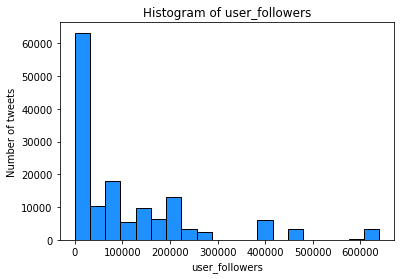

Summary Statistics:
count    144103.000000
mean       4589.168553
std        5743.790933
min           0.000000
25%         533.000000
50%        1613.000000
75%        7520.000000
99%       22933.000000
max       22933.000000
Name: user_likes, dtype: float64


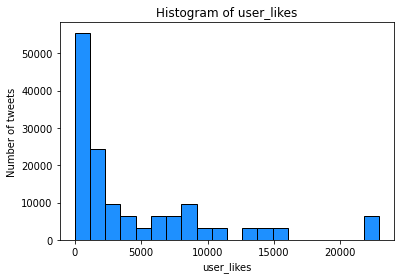

Summary Statistics:
count    144103.000000
mean      35026.181835
std       65256.361525
min           4.000000
25%        3234.000000
50%        6921.000000
75%       31853.000000
99%      317563.000000
max      317563.000000
Name: user_tweets, dtype: float64


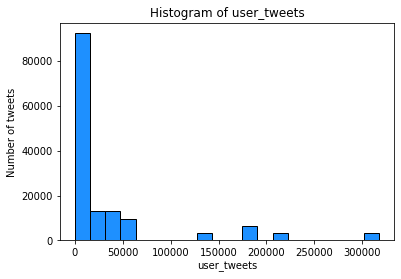

Summary Statistics:
count    144103.000000
mean         22.461413
std         171.999327
min           0.000000
25%           0.000000
50%           3.000000
75%          12.000000
99%         316.000000
max       29766.000000
Name: tweet_likes, dtype: float64


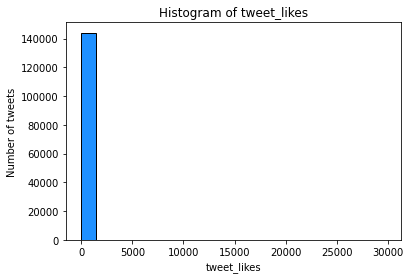

Summary Statistics:
count    1.441030e+05
mean     2.751278e+02
std      1.471482e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      5.000000e+00
99%      4.720000e+02
max      3.192070e+06
Name: tweet_retweets, dtype: float64


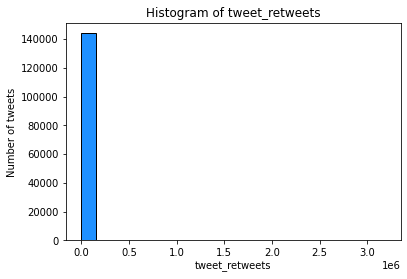

In [ ]:
# Description of numerical variables & plot histogram
# Select numerical features to plot
num_features = ['user_followers','user_likes','user_tweets',
                'tweet_likes','tweet_retweets' ]

# Plot histogram
for x in num_features:
    print('Summary Statistics:')
    print(df[x].describe(percentiles = [.25, .5, .75, 0.99]))                   # Add 99th percentile in summary statistics to better understand spread of data
    plt.hist(df[x], color = 'dodgerblue', edgecolor = 'black',
         bins = int(20))
    plt.title('Histogram of '+ x)
    plt.xlabel(x)
    plt.ylabel('Number of tweets')
    plt.show()

In [ ]:
# Find extreme values for user_followers, user_likes, tweets
print('Extreme values for')
print('Follower counts:')
print(df['name'].loc[df['user_followers']> 500000].unique())
print('Like counts:')
print(df['name'].loc[df['user_likes']> 20000].unique())
print('Tweet counts:')
print(df['name'].loc[df['user_tweets']> 300000].unique())

Extreme values for
Follower counts:
['9News Australia' 'Hamish Blake']
Like counts:
['Channel 7' 'Johanna Griggs AM']
Tweet counts:
['9News Australia']


Findings from numerical features EDA:
 - Better understood spread of several numerical variables
 - Users with high followers, likes and tweets, using domain knowledge, these are sensible and no fixing required
 - Extreme values for 'tweet_likes' and 'tweet_retweets', scaling of these variables will be important for Neural networks

**6) EDA Summary of Findings**

This section summarises information that has been gathered in EDA
- Shape of data consists of 147,421 rows of tweets, and 14 columns
- Sampling of data to understand fields
- Sampling of tweet_text to understand text field we are dealing with
- Found and removed duplicates
- List of usernames is not long - 62 users posted the 147,000 tweets
- Range/spread of numerical variables

#NLP and Unsupervised Learning
This section of the notebook conducts the Natural Language Processing(NLP) and Unsupervised Learning (PCA and k-means) portions of the investigation. 

In this segment, the main dataset is vectorised using the BERT model whilst TFIDF is applied to a smaller sample dataset to demonstrate how lemmatisation and and removal of stopwords can be applied. PCA is performed on the TFIDF vectorised text whereas k-means is performed on the BERT vectorised text. 

This choice done due to memory issues encountered when running PCA on the TDIDF vectorised text, TDIDF produces an array for each word in the corpus and PCA does not work. Whilst methods to apply PCA on large datasets exist such as Randomised Singlular Value Decomposition(random SVD) exist, for the purpose of this investigation, the performance and ease-of-use of BERT has been favoured. A second alternative would be to remove more words in the cleaning step, for example remove words with low frequency, however due to the loss of information this is not preferred. 

Whilst transfer learning off BERT base models is not recommended for twitter text as base BERT was modelled on moderated text, sentence-BERT models have been trained on general written language and perform well with embedding tasks. https://arxiv.org/pdf/1908.10084.pdf


#### Clean
The cleaning steps taken for TFIDF are:
 - Removing timestamps: From EDA many tweets included showtimes which will not add any meaning to our text.
 - Removing Hyperlinks - Hyperlinks do not add value
 - Removing Hashtags - From EDA, hashtags mainly used the shows or reinterated the text in the tweet, do not think they will add value
 - Convert Emojis into words - Found that emojis expressed the tone of the tweet well at times. Users also used emojis in place of words so we should capture this information
 - Spell checking is not suitable as tweets are more informal and the television industry will use words not found in the dictionary.
 - Stopwords are removed for TFIDF  

Doing individual cleaning steps through the clean_text function to check that function is working as intended

In [ ]:
# Use the first 'tweet_text' entry
test_text = df['tweet_text'].iloc[0]

# Create list of stop words to remove in cleaning
stopwords = nltk.corpus.stopwords.words('english')

# Add some common words to the dictionary that are likely to be found in the
# case study corpus, to avoid them being incorrectly 'fixed' by the spell checker.
sym_spell.create_dictionary_entry('covid', 2)
sym_spell.create_dictionary_entry('coronavirus', 2)
sym_spell.create_dictionary_entry('covid-19', 2)
sym_spell.create_dictionary_entry('pfizer', 2)
sym_spell.create_dictionary_entry('moderna', 2)

# Perform individual cleaning steps, step by step

# Remove times
test_text1 = clean_text(test_text, rmTimes=1, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=0)  
# Remove Links
test_text2 = clean_text(test_text, rmTimes=0, rmlinks=1, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=0)
# Remove Hashags
test_text3 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=1, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=0)
# Remove Retweets
test_text4 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=1, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=0)
# Emojis to words
test_text5 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=2, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=0)
# Spelling fix - Add a typo first
test_text6 = re.sub("future","futureZ", test_text)
test_text6 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=1, rmStopwords=0, stem_ind=0, lemm_ind=0)
# Remove stopwords
test_text7 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=1, stem_ind=0, lemm_ind=0)
# Stemming
test_text8 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=1, lemm_ind=0)
# Lemmatization
test_text9 = clean_text(test_text, rmTimes=0, rmlinks=0, rmHT=0, rmRT=0, emoji_ind=0, spell_ind=0, rmStopwords=0, stem_ind=0, lemm_ind=1)

# Print output
print('Original text:')
print(test_text)
print('\n'+'Remove Times:')
print(test_text1)
print('\n'+'Remove Hyperlinks:')
print(test_text2)
print('\n'+'Remove Hashtags:')
print(test_text3)
print('\n'+'Remove Retweets:')
print(test_text4)
print('\n'+'Emojis to words:')
print(test_text5)
print('\n'+'Spelling Fixer:')
print(test_text6)
print('\n'+'Remove Stopwords:')
print(test_text7)
print('\n'+'Stemming:')
print(test_text8)
print('\n'+'Lemmatization:')
print(test_text9)

Original text:
The future of justice begins with her. ⚡️

#WonderWoman Tonight 8.30 https://t.co/1toX55fvQ4

Remove Times:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'wonderwoman', 'tonight', 'httpstco1tox55fvq4']

Remove Hyperlinks:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'wonderwoman', 'tonight', '830']

Remove Hashtags:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'tonight', '830', 'httpstco1tox55fvq4']

Remove Retweets:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'wonderwoman', 'tonight', '830', 'httpstco1tox55fvq4']

Emojis to words:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'zap', 'wonderwoman', 'tonight', '830', 'httpstco1tox55fvq4']

Spelling Fixer:
['the', 'future', 'of', 'justice', 'begins', 'with', 'her', 'washerwoman', 'tonight', 'the']

Remove Stopwords:
['future', 'justice', 'begins', 'wonderwoman', 'tonight', '830', 'httpstco1tox55fvq4']

Stemming:
['the', 'futur', 'of', 'justic', 'begi

The step change sees that the code is working as intended for this test case. A more comprehensive check on the cleaning function is to look at cleaned text which is done later on the full dataset. 

We also observe that the spelling fixer should not be applied due to the informal text present in tweets, TV shows and characters will get picked up by the spell-fixer. Stemming also deconstructs words incorrectly and will not be applied

Perform cleaning on two datasets - one for BERT 

*   List item
*   List item

vectorisation and one for TFIDF

BERT cleaning: 


In [ ]:
# Clean dataset for BERT vectorisation
# Remove times/hyperlinks/retweets
# Stopwords can be left in for BERT 
df['clean_text_bert'] = [clean_text(i,
                                 rmTimes=1,                                      # remove times
                                 rmlinks=1,                                      # remove hyperlinks                      
                                 rmHT=1,                                         # remove hashtags   
                                 rmRT=1,                                         # remove retweets   
                                 emoji_ind=1,                                    # emoji treatment,  
                                 spell_ind=0,                                    # Spell checking    
                                 rmStopwords=0,                                  # Remove stopwords   
                                 stem_ind=0,                                     # Stemming          
                                 lemm_ind=0)
                                for i in df['tweet_text']]
print(df['clean_text_bert'])

#Check against original tweets to check cleaning process
print(df['tweet_text'])

0                                                                                            [the, future, of, justice, begins, with, her, tonight]
1         [millions, of, queenslanders, have, been, plunged, into, lockdown, for, three, days, after, more, cases, of, covid19, were, detected, in]
2                                                    [the, live, grand, final, is, here, the, winner, of, will, be, decided, tonight, on, channel7]
3                                                                                                      [graham, arnold, has, high, hopes, for, the]
4                                                            [its, time, for, australia, to, decide, who, wins, big, brothers, game, vote, now, at]
                                                                            ...                                                                    
116094                                                                                                          

In [ ]:
# tfidf dataset
df_tfidf = df.copy()
df_tfidf = df_tfidf.head(1000)
# Clean dataset for BERT vectorisation
# Remove times/hyperlinks/retweets
# Stopwords can be left in for BERT 
df_tfidf['clean_text_tfidf'] = [clean_text(i,
                                 rmTimes=1,                                      # remove times
                                 rmlinks=1,                                      # remove hyperlinks                      
                                 rmHT=1,                                         # remove hashtags   
                                 rmRT=1,                                         # remove retweets   
                                 emoji_ind=1,                                    # emoji treatment,  
                                 spell_ind=0,                                    # Spell checking    
                                 rmStopwords=1,                                  # Remove stopwords   
                                 stem_ind=0,                                     # Stemming          
                                 lemm_ind=1)
                                for i in df_tfidf['tweet_text']]
print(df_tfidf['clean_text_tfidf'])

#Check against original tweets to check cleaning process
print(df_tfidf['tweet_text'])

0                                                                               [future, justice, begin, tonight]
1                                [million, queenslanders, plunged, lockdown, three, day, case, covid19, detected]
2                                                        [live, grand, final, winner, decided, tonight, channel7]
3                                                                                    [graham, arnold, high, hope]
4                                                        [time, australia, decide, win, big, brother, game, vote]
                                                          ...                                                    
1013          [world, given, fresh, shot, hope, uk, grandmother, became, first, person, receive, pfizer, covid19]
1014                                                                      [old, school, meet, new, life, tonight]
1015              [12, year, hair, loss, 64yearold, sylvia, regains, new, head, hair, bo

#### TFIDF Vectorisation

In [ ]:
# Convert cleaned tweets into a series for vectorisation
clean_input = [listToString(i)for i in df_tfidf['clean_text_tfidf']]
clean_input = pd.Series(clean_input)

# Generate TF-IDF weights
tfidf = TfidfVectorizer()
embedding_tfidf = tfidf.fit_transform(clean_input)
print('Shape of list containing reviews and their tf-idf weights:', embedding_tfidf.shape)
### Shape should equate to (count of tweets, distinct words in tweets)

Shape of list containing reviews and their tf-idf weights: (1000, 2968)


### BERT Vectorisation

In [ ]:
# BERT Input
bert_input = [listToString(i)for i in df['clean_text_bert']]
bert_input = pd.Series(bert_input)

In [ ]:
# Import the BERT data set (the text that has only had basic cleaning).
bert_input = bert_input.tolist()
print('Getting vector embeddings for BERT ...')

# Create a model to perform embeddings using BERT.
model = SentenceTransformer('all-mpnet-base-v2')

# Perform the embeddings.
embeddings = model.encode(bert_input, show_progress_bar=True)
embedding_BERT = np.array(embeddings)

print('Getting vector embeddings for BERT. Done!')

print('Shape of list containing reviews and their BERT weights:', embeddings.shape)

Getting vector embeddings for BERT ...


Batches:   0%|          | 0/4504 [00:00<?, ?it/s]

Getting vector embeddings for BERT. Done!
Shape of list containing reviews and their BERT weights: (144103, 768)


### PCA

Question 3 b)

**Advantages of applying PCA**

**Dimensionality & correlation reduction**

The first advantage of applying PCA to our vectorized text is that it reduces the correlation between word features by combining correlated words into principal components. This is advantageous to us in the clustering portion of analysis as the performance of the k-means algorithm will be improved by having a lower number of features that are independent as opposed to a large number of correlated features which might be susceptible to overfitting – i.e producing non-meaningful clusters. 


**Deterministic output** 


PCA is deterministic, and hence when applying PCA as opposed to other stochastic dimension reduction techniques, we can be sure to return the same principal components each time. This is compared to a stochastic algorithm such as t-distributed stochastic neighbour embedding (TSNE) which does a random walk in order to determine relationships in the data. Producing reproducible results is advantageous in this context as the single solution can be more useful in explaining to stakeholders the output of the dimension reduction process.

**Disadvantages of applying PCA**

**Only captures linear relationships**

PCA transforms variables into linear combinations of the variables. This works if the features are linearly correlated to each other. If the relationships between the vectorized words in our dataset are not linearly correlated, applying PCA might fail to capture some of these relationships. Again, contrasting to TSNE as an example of an algorithm that does capture non-linear relationships between features.

**Interpretability**

A disadvantage of applying PCA is that our tweet texts becomes less interpretable. It is less clear what the principal component represents rather than something easier to understand, such as the frequency of a particular word. We would need to first consider the composition of each principal component to try and figure out the correlation between the features in it. 


Formatting Data and Scaling before performing PCA

In [ ]:
# Formatting of TDIFDF output to run through PCA data 
tfidf_array = embedding_tfidf.toarray()

# Create headings for array 
headings = tfidf.get_feature_names()

# Preparing data to fit into PCA model
sc = StandardScaler()
sc.fit(tfidf_array)
pca_data = sc.transform(tfidf_array)

# Check that standard scaling has been applied
print(pca_data[:1])

[[-0.0939179  -0.0316386  -0.06262274 ... -0.0316386  -0.05467929
  -0.0316386 ]]


Perform PCA and plot screeplot to visualise the variance explained by each principal component

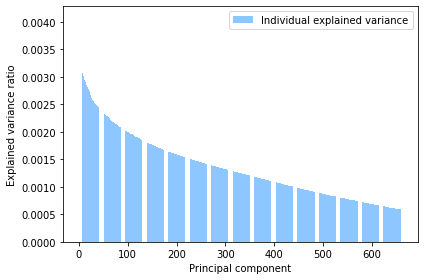

In [ ]:
# Initiate the PCA.
pca = PCA(n_components = 0.90)

# Fit the PCA model to determine the transformed features.
pca.fit_transform(pca_data)

# Use the 'plot_explained_variances' function defined at the top of the
# notebook to plot the variance explained by each principal component.
plot_explained_variances(pca)

In [ ]:
# Find the variance explained by the first 660 components
pca_variance = pca.explained_variance_ratio_[0:660]
print ('Variance explained by 660 principal components: '+str(pca_variance.sum()))

Variance explained by 660 principal components: 0.9005408282874755


The initial number of features of 2968 word vectors has been reduced to 660 principal components that explain 90% of the variance in the dataset used

In [ ]:
# Print top words used in leading PCA components -
# Check for common theme in words that comprise the PCAs
pca1_list = pca.components_[0].tolist()
word_index = sorted(range(len(pca1_list)), key=lambda x: pca1_list[x], reverse = True)[:20]

[headings[i] for i in word_index]

['arthur',
 'martin',
 'bryant',
 'port',
 'massacre',
 'dark',
 'document',
 'longlost',
 'bryants',
 'reveals',
 'denhamhitchcock',
 'killed',
 'uncovers',
 'speaks',
 'investigation',
 'may',
 'witness',
 '7newsspotlight',
 'arsenal',
 'busy']

The words that contain the highest weights in creating the first principal component relate to the Port Arthur massacre. Whilst grim, this is some validation that PCA was effective at reducing the individual word vectors into principal components with a common theme/topic.

## k-means 

1234567891011121314151617181920212223242526272829303132333435363738394041424344

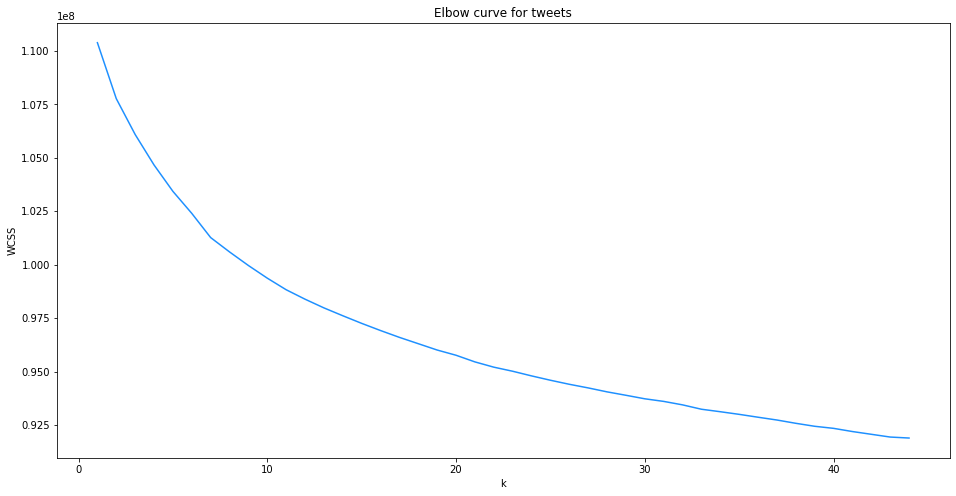

In [ ]:
# Create a separate array of tweets/words for k_means
bert_array = embedding_BERT
#
## Create a scaler so that the features in the dataset can be
## scaled to have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
#
## Calculate the WCSS or inertia for different values of K.
WCSS = []
K = range(1,45)
for k in K:
    kmeans2 = KMeans(n_clusters=k,init='k-means++')
    pipeline2 = make_pipeline(scaler,kmeans2)
    pipeline2.fit(bert_array)
    WCSS.append(kmeans2.inertia_)
    print(k,end = "")

## Plot the elbow curve. 
plt.figure(figsize=(16,8))
plt.plot(K, WCSS,color='dodgerblue')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow curve for tweets')
plt.show()

The WCSS scores which measures the variability within each cluster shows inter cluster variability drops off quickly initially and there is a first kink at 7 clusters. However, choosing clusters at k ~ 12 and 22 can be argued for too. We choose 12 as this seems like a sensible choice of clusters on the topics that tweets can revolve around from EDA (sports, reality tv, news, current affair issues, documentaries, competition series etc).

In [ ]:
# Perform K-means clustering on tweets.
bert_array = embedding_BERT

# Create a scaler so that the features in the dataset can be
# scaled to have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

# Create a KMeans model with k clusters.
# Come back after plotting elbow curve
k = 12
kmeans = KMeans(n_clusters=k,init='k-means++',random_state=1234)

# Create a pipeline to link together the scaler and kmeans instance.
pipeline = make_pipeline(scaler,kmeans)

# Build a K-means clustering model by fitting the pipeline to the tweets dataset.
kmeans = pipeline.fit(bert_array)

Internal Validation - Two internal validation measures are calculated
Silhouette score and Davies-Bouldin Score

In [ ]:
# Calculate the silhouette value for the BERT based clustering that
# has been applied to reduce the dimension of the embeddings.
print('Silhouette Score:', 
      silhouette_score(embedding_BERT , labels_bert_kmeans))

Silhouette Score (BERT and t-SNE): 0.019928936


The silhouette score looks at how consistent the data is within each cluster compared to other clusters. i.e a measure of how distinguished the clustering outcome is. By its formulation, the range of the score is -1 to 1 and the score of 0.2 means that the clusters produced here are not entirely overlapping but are also not too clearly distinguished from each other.

In [ ]:
# Calculate Davies Bouldin Score
# Calculate the silhouette value for the BERT based clustering that
# has been applied to reduce the dimension of the embeddings.
print('Davies-Bouldin index:', 
      davies_bouldin_score(embedding_BERT, labels_bert_kmeans))

Davies-Bouldin index: 4.720223955105569


The Davies-Bouldin index also measures intra and inter cluster variation. By its formulation, the lower the score the better, with 0 being the minimum. A score of 4.7 again shows that our clusters are not too distinguished from one another.

Manual Validation

The visual tool to assist with Manual validation chosen here is the wordcloud to identify topics through common words found within a cluster

144103
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 10 ...
Getting wordcloud for topic 11 ...
Getting wordcloud for topic 12 ...


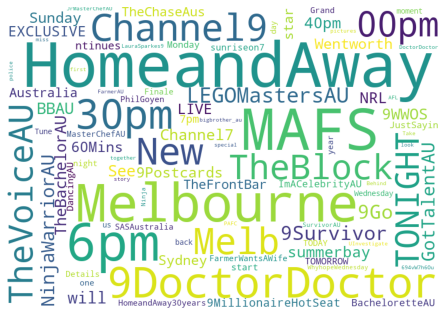

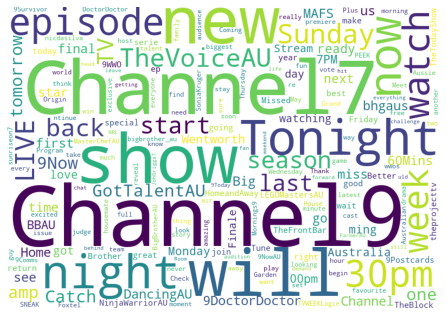

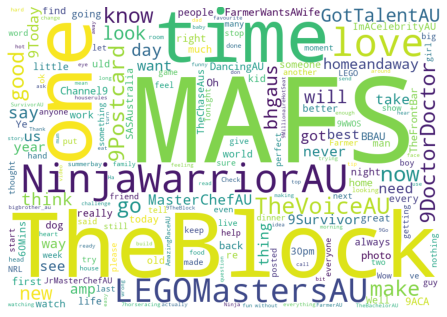

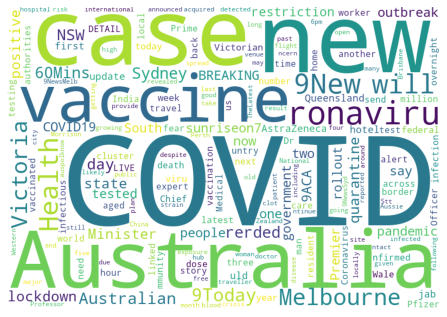

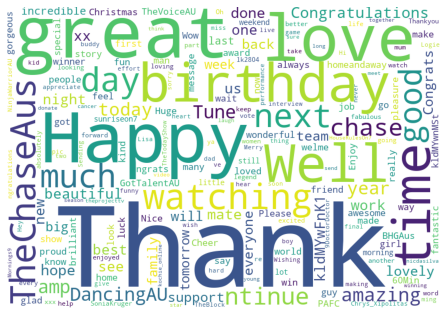

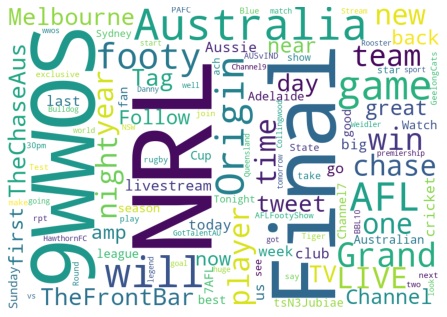

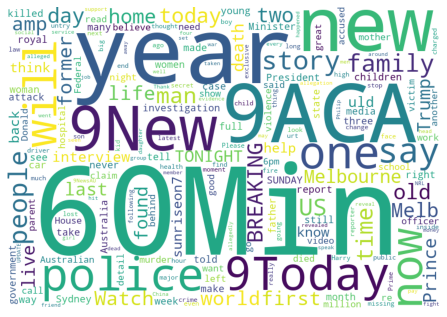

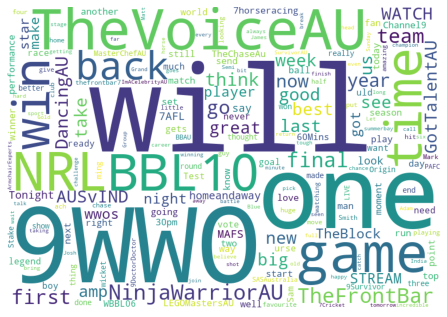

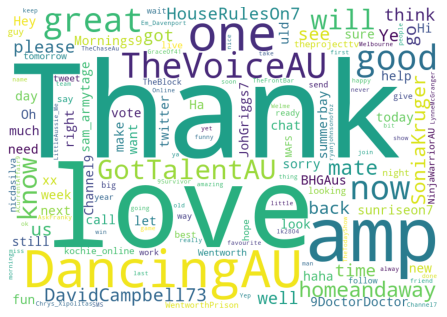

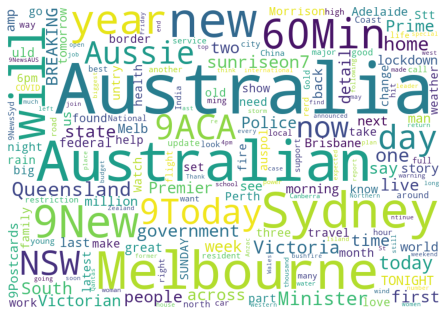

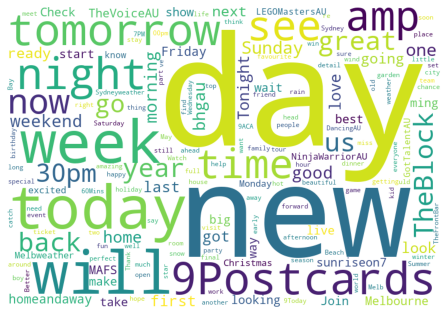

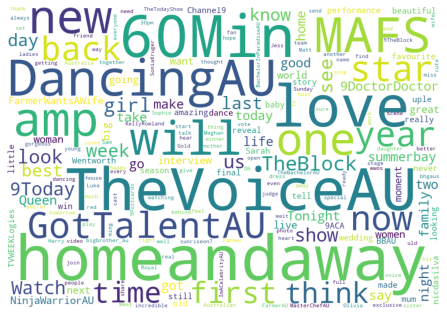

In [ ]:
# Plot a wordmap of common words used in each k-means cluster 
# Create array of labels for tweets
labels_bert_kmeans = kmeans.predict(bert_array)

## Check that the length = number of tweets 
print(len(labels_bert_kmeans))

## Converting clustering labels into arrays and a set
labels1 = np.array(labels_bert_kmeans)
distinct_labels1 =  set(labels_bert_kmeans)

## Labelling original data into which cluster they fell into
df['label_bert_KMeans'] = list(labels_bert_kmeans)

# Add list of words to hide from word cloud
hidden_words = ['7plus','7News','co','https','RT', '7NEW','tonight'] 

# Create a word cloud to help identify the meaning of
# each 'topic' identified in the KMeans clustering.
for each in range(0,k):
    get_wordcloud(each,'label_bert_KMeans',hidden_words)

Applying manual validation, the knowledge gained through domain knowledge is useful here.

Pieces of domain knowledge that are useful here are that sports are usually played on these channels, with the channels having broadcasting rights to NRL, AFL and cricket. We also know that there is currently a pandemic occuring with lockdowns happening. Some of the primetime TV shows include: {'Married at First Sight', 'Home and Away', 'The Voice', 'The Block', 'Ninja Warrior'}  

Overall, it does seem that manual validation reinforces what was found in internal validation, that there is some overlap between the clusters created, with the names of a single show appearing in multiple clusters. Some clusters do seem to be distinct and are discussed in further detail below

Getting wordcloud for topic 4 ...


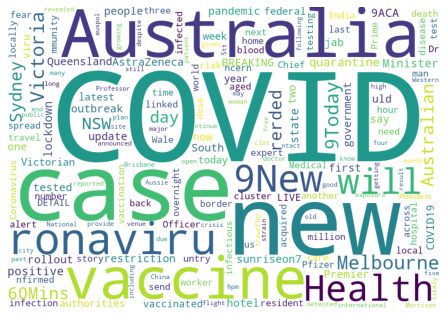

In [ ]:
# Wordcloud for Topic 4
get_wordcloud(3,'label_bert_KMeans',hidden_words)

This cluster has quite distinctly grouped tweets relating to the covid-19 pandemic with the key words such as 'vaccine', 'outbreak' and 'restrictions' appearing. It seems that the BERT embeddings were able to identify health and pandemic related sentences and k-means successfully grouped these tweets into their own cluster.   

Getting wordcloud for topic 6 ...


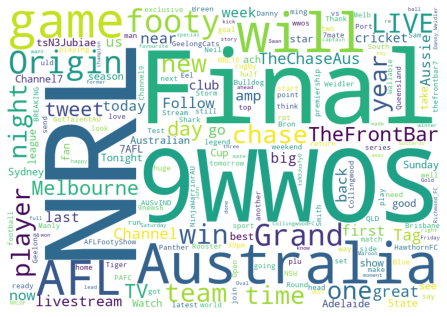

In [ ]:
# Wordcloud for Topic 6
get_wordcloud(5,'label_bert_KMeans',hidden_words)

This cluster has quite distinctly grouped tweets relating to sporting events with the key words such as 'NRL', 'Final' and 'Geelongcats' appearing. It seems that the BERT embeddings were able to identify sport related sentences and k-means successfully grouped these tweets into their own cluster.  

In [ ]:
# Create data stamp after kmeans
#df.to_csv('/content/gdrive/My Drive/Datasets/data_kmeans.csv')

# Share Price Model

## EDA Share Price Data

The share chosen is NEC as during the domain research phase of the investigation, a finding is that SVW's media business only comprises a fraction of its overall business and the relationship between tweet sentiment and share price will be weaker. 

Data Exploration on Share data

Steps in this EDA are: 
 - Understand shape of data
 - Visualise data
 - Explore distinctness of data

Investigate shape of data and columns provided

In [ ]:
## Investigate share price data
print('Shape of data: ',df_shares.shape,'\n')
print(df_shares.info())

Shape of data:  (9159, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9159 entries, 0 to 9158
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Code          9159 non-null   object 
 1   Exchange      9159 non-null   object 
 2   SrcTime       9159 non-null   object 
 3   GMT           9159 non-null   object 
 4   Open          9159 non-null   float64
 5   High          9159 non-null   float64
 6   Low           9159 non-null   float64
 7   Close         9159 non-null   float64
 8   Volume        9159 non-null   int64  
 9   Value         9159 non-null   float64
 10  Transactions  9159 non-null   int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 787.2+ KB
None


Nulls not an issue with share data

In [ ]:
## Explore data structure by viewing top 5 rows
pd.options.display.float_format = '{:,.2f}'.format
df_shares.head(5)

,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,NEC,ASX,1/07/2020T10:00:00,1/07/2020T0:00:00,138.50,139.00,137.00,138.25,262997,"362,612.86",177
1,NEC,ASX,1/07/2020T10:10:00,1/07/2020T0:10:00,138.50,139.00,137.50,137.75,255503,"353,482.35",129
2,NEC,ASX,1/07/2020T10:20:00,1/07/2020T0:20:00,137.75,138.50,137.75,138.00,60596,"83,654.97",47
3,NEC,ASX,1/07/2020T10:30:00,1/07/2020T0:30:00,138.50,139.50,138.50,139.50,138923,"193,207.13",90
4,NEC,ASX,1/07/2020T10:40:00,1/07/2020T0:40:00,139.50,140.00,139.50,139.50,93188,"130,133.13",72


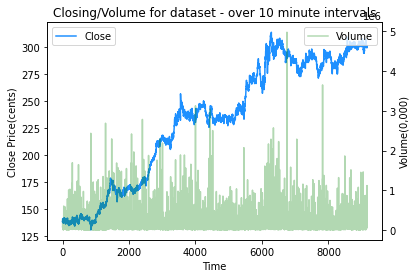

In [ ]:
# Visualise Volume and Close price over time
# Set up plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot( df_shares['Close'], color = 'dodgerblue', label = 'Close')
ax2.plot( df_shares['Volume'], 'green', label = 'Volume', alpha = 0.3)

# Set labels
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price(cents)')
ax2.set_ylabel('Volume(0,000)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Closing/Volume for dataset - over 10 minute intervals')

plt.show()

The plot shows Close price and volume over the length of the data set. 

Observations here are:
 - The share price has increased over the duration of the period.
 - The continuous variables look sensible

Next we check whether the times given are distinct

In [ ]:
# Check that share prices are distinct
print('Distinct times(Src): ' + str(df_shares['SrcTime'].nunique()))
print('Distinct times(GMT): ' + str(df_shares['GMT'].nunique()))
print('Length of data: ' + str(len(df_shares)))

Distinct times(Src): 9159
Distinct times(GMT): 9154
Length of data: 9159


We find that 'GMT' contains some duplicate time stamps and should investigate further

In [ ]:
# Create column of counts
df_shares['Count_GMT'] = df_shares['GMT'].map(df_shares['GMT'].value_counts())

# print rows in data where duplicate GMT times were found
df_shares.loc[df_shares['Count_GMT']>1].sort_values(by = 'GMT')

,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions,Count_GMT
2413,NEC,ASX,30/09/2020T11:30:00,30/09/2020T1:30:00,177.50,177.50,177.00,177.25,99280,"176,149.64",77,2
2419,NEC,ASX,30/09/2020T12:30:00,30/09/2020T1:30:00,178.00,179.00,177.50,179.00,197673,"351,941.54",160,2
2422,NEC,ASX,30/09/2020T13:00:00,30/09/2020T3:00:00,178.25,179.00,178.00,178.50,68897,"122,935.01",59,2
2428,NEC,ASX,30/09/2020T14:00:00,30/09/2020T3:00:00,179.00,179.00,178.50,178.50,43294,"77,403.22",66,2
2431,NEC,ASX,30/09/2020T14:30:00,30/09/2020T4:30:00,176.75,176.75,175.50,175.50,121461,"213,859.65",150,2
2437,NEC,ASX,30/09/2020T15:30:00,30/09/2020T4:30:00,175.75,176.25,175.50,175.75,307924,"541,603.58",175,2
2433,NEC,ASX,30/09/2020T14:50:00,30/09/2020T4:50:00,175.50,176.00,175.50,175.75,45901,"80,647.63",101,2
2439,NEC,ASX,30/09/2020T15:50:00,30/09/2020T4:50:00,175.75,176.00,174.00,174.00,495796,"869,989.33",566,2
2435,NEC,ASX,30/09/2020T15:10:00,30/09/2020T5:10:00,175.50,176.00,175.50,175.50,78771,"138,356.78",136,2
2440,NEC,ASX,30/09/2020T16:10:00,30/09/2020T5:10:00,174.50,174.50,174.50,174.50,1776368,"3,099,762.16",132,2


We see that there is no clear reason why GMT is duplicating in these rows. The outcome of this is that the investigation will stick to using SrcTime.

## Create a suitable response variable for share price movement



In creating a response variable, with the share price data given - considerations include: the right metric and the relevant time period to look at that metric. Investigate several options to come up with a suitable response. 

**Option 1**: 

This option is be the most intuitive and the base option to use. It would be finding the 'Close' price just before the tweet and after the tweet and comparing the two. If the price has gone up then the response variable would be an increase an vice-versa.

Advantages: 
 - Most intuitive
 - Simple to calculate
 - Easy to explain to stakeholders
 - Can account for tweets during the night the next price would be at 10:00am the next day and the pre-market would have moved it 

Disadvantages: 
 - Using 1 data point could introduce alot of volatility
 - Does not account for volume of shares traded in that interval
 - Does not account for how much a share has moved

**Option 2**

Option 2 builds on option 1 by considering the average of prices over a specified number of intervals, say for n = 6 prices, before and after the tweet was posted.

Advantages:

- Like option 1 relatively intuitive
- Relatively easy to calculate

Disadvantages: 
 - Does not account for volume of shares traded in the period
 - Does not account for how much a share has moved, a 1 cent increase is still an increase

**Option 3**

Option 3 again builds on option 2, instead of comparing directly before and after prices, we only classify it as a movement if it exceeds a certain %(alpha). 

*Example:*

For an alpha of 0.05, a share averaged 100 cents before a tweet 

-> Classify as 'Increased' if it averaged above 105 after the tweet,

-> Classify as 'Same' if it averaged Above 95 and under 105 after the tweet,

-> Classify as 'Decreased' if it averaged below 95 after the tweet,


Advantages:

- Removes some of the volatility in share price movement by introducing a threshold movement and allows for an averaging of multiple prices.

Disadvantages: 
 - Does not account for volume of shares traded in the period
 - In the investment context, we might 'miss' some gains as some of the positive or negative sentiments will now be captured as a neutral sentiment as the share remained the same
 - Extra calculation required

**Option 4**

In option 4, we address the drawbacks in the previous options not allowing for the volume of shares traded. Volume could be important in sentiment as to an extent it shows a level of interest in the share.
To overcome this, firstly calculate a Volume-Weighted Average Price(VWAP) at each time period. The VWAP provides insight into both the trend and value of a security and its calculation involves keeping a cumulative track of price*volume over cumulative volume. 

Then use the previous methodology of calculating an average n VWAP before and after a tweet and applying an alpha to determine movement.

Advantages:

- Allows for volume
- Removes some of the volatility in share price movement

Disadvantages:

 - VWAP is not as intuitive as using a 'Close' price
 - Calculation is more involved

Decide on **Option 4** as capturing volume should create a more meaningful response variable. The number of 10min intervals to capture is more subjective choice but a period of 18 intervals(3hours) should capture the share sentiment but whilst not having the tweet impact run out.  

The calculation of share indicator comprises of 4 main steps:


1) Convert tweet_text_time in UTC to SRC so times are comparable

2) Create a Volume Weighted Average Price column in Shares dataset

3) Use find_share_price function defined in functions to get the average VWAP before and after each tweet

4) Create indicator function 

1) Convert time

In [ ]:
# Convert UTC time to Sydney time for tweets
# Using function defined in functions
print('Original UTC time:' + df['tweet_post_time'][0])
df['tweet_post_time'] = [convert_timezone(i) for i in df['tweet_post_time']]
print('Converted Sydney time:' + df['tweet_post_time'][0])

Original UTC time:29/06/2021 4:00
Converted Sydney time:29/06/2021 14:00


**2**) VWAP Calculation

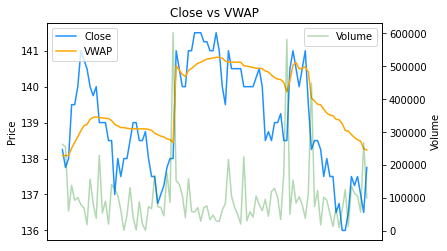

In [ ]:
# VWAP calculation
# Create date time column in shares
df_shares['date'] = [datetime.strptime(i,"%d/%m/%YT%H:%M:%S").date() for i in df_shares['SrcTime']]

# Take an average of High, Low and Close as the price and multiply this by volume
df_shares['TPV'] = df_shares.apply(lambda x: (x['High']+ x['Low']+ x['Close'])/3 * x['Volume'],axis = 1)       

# Calculate VWAP
df_shares['Cumulative_TPV'] = df_shares.groupby(['date'])['TPV'].cumsum()
df_shares['Cumulative_Volume'] = df_shares.groupby(['date'])['Volume'].cumsum()
df_shares['VWAP'] = df_shares.apply(lambda x: x['Cumulative_TPV']/x['Cumulative_Volume'], axis = 1)

# Plot Close vs VWAP as a check
# Set up plot data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_shares['Close'].head(100), color = 'dodgerblue', label = 'Close')
ax1.plot(df_shares['VWAP'].head(100), 'orange', label = 'VWAP')
ax2.plot(df_shares['Volume'].head(100), color =  'green',label = 'Volume', alpha = 0.3)
# Labelling
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax2.set_ylabel('Volume')
ax1.axes.xaxis.set_visible(False)
ax1.legend(loc='upper left')
plt.legend(loc='upper right')
plt.title('Close vs VWAP' )

plt.show()

The graph shows that our VWAP calculation is working as intended, the VWAP is a cumulative calculation and we expect it to be smoother than 'Close'. We also see that the VWAP moves in line with 'Close' only when there is corresponding volume behind the price movement. 

This is most clearly seen by comparing VWAP when 'Close'(blue) first spikes to 141 vs the second spike. The spike with volume in the second time saw VWAP increase whils the first did not


3) Find the average VWAP before and after each tweet, in line with option 4 discussed at the start of this section.

Parameters for find_nearest_price are:

 - n : 18 this means the average VWAP of 18 periods before and after are considered in line with our selection period of 3 hours

 - before_after: calculate metric for both before and after

 - metric: 'vwap', alternative is to use 'close' if we want to implement options 1-3

In [ ]:
# Option 4
# Find nearest 
# Create array of datetimes for shares
time_stamp = [datetime.strptime(i,"%d/%m/%YT%H:%M:%S") for i in df_shares['SrcTime']]
df_shares['shares_dt'] = [datetime.strptime(i,"%d/%m/%YT%H:%M:%S") for i in df_shares['SrcTime']]
share_times_array = np.array(time_stamp)  
earliest_share_date = min(time_stamp)
latest_share_date = max(time_stamp)

# Find nearest times before and after
# Convert string time into a date time format
df['tweet_dt'] = [datetime.strptime(i,"%d/%m/%Y %H:%M") for i in df['tweet_post_time']]

# Select tweets only after the earliest share date and before the latest share date
df_models = df.copy()
df_models = df_models.loc[(df_models['tweet_dt'] > earliest_share_date) & (df_models['tweet_dt'] < latest_share_date)] 

# Run 
df_models['price_before'] = df_models['tweet_dt'].progress_apply(lambda x : find_share_price(x, n =18, before_after = 'before', metric = 'vwap'))
df_models['price_after'] = df_models['tweet_dt'].progress_apply(lambda x : find_share_price(x, n =18, before_after = 'after', metric = 'vwap'))
#df_models.to_csv('/content/gdrive/My Drive/Datasets/assignment_data.csv')

  0%|          | 0/46208 [00:00<?, ?it/s]

  0%|          | 0/46208 [00:00<?, ?it/s]

Check that the function is doing what it is supposed to by doing a manual calculation on the first tweet in df_models

In [ ]:
# Print the tweet and calculated after metric
print('Test Case tweet: '+'\n') 
print(df_models.loc[:0,['tweet_post_time','tweet_dt','price_after']])

# We find the VWAP values for the 18 times after the tweet
# and find the average of these 18 values
# Recall that VWAP calulation has already been checked above
y = df_shares[['SrcTime','VWAP']].loc[df_shares['date']== datetime(2021,6,23).date()][21:39]
avg_vwap = y['VWAP'].mean()

# Print results
print('\n'+'Return times and calculated VWAP for 18 prices after the tweet time: '+'\n')
print(y)
print('\n' +'Manual Calculation Value: ' + str(round(avg_vwap,2)))

Test Case tweet: 

    tweet_post_time             tweet_dt  price_after
0  23/06/2021 13:29  2021-06-23 13:29:00       303.06

Return times and calculated VWAP for 18 prices after the tweet time: 

                  SrcTime   VWAP
9143  23/06/2021T13:30:00 303.52
9144  23/06/2021T13:40:00 303.47
9145  23/06/2021T13:50:00 303.43
9146  23/06/2021T14:00:00 303.38
9147  23/06/2021T14:10:00 303.33
9148  23/06/2021T14:20:00 303.29
9149  23/06/2021T14:30:00 303.25
9150  23/06/2021T14:40:00 303.20
9151  23/06/2021T14:50:00 303.16
9152  23/06/2021T15:00:00 303.12
9153  23/06/2021T15:10:00 302.99
9154  23/06/2021T15:20:00 302.93
9155  23/06/2021T15:30:00 302.89
9156  23/06/2021T15:40:00 302.72
9157  23/06/2021T15:50:00 302.37
9158  23/06/2021T16:10:00 301.88

Manual Calculation Value: 303.06


The manual calculation returns a value of 303.06 which is the same as what the function returned and we are satisfied to move on to the next step which is to define the indicator function based on before and after metrics

4) Define an indicator that returns 'Increased' if the average VWAP was more than 100.5% and less than 99.5%. The alpha selected here is chosen for a reasonable number of splits between the 3 categories.  

In [ ]:
# Create indicator for share price
# using share_indicator function defined in 'Functions'
df_models['Indicator'] = df_models.apply(lambda x: 
                                         share_indicator(x['price_after'], x['price_before'], alpha = 0.005),
                                         axis = 1)  

# Check counts of Indicator
df_models['Indicator'].value_counts()

Increased    17138
Same         16828
Decreased    12242
Name: Indicator, dtype: int64


By defining the indicator based on a selected value of alpha, this has a benefit in helping to create a balanced(relatively similar counts for each label) dataset for modelling.

A sense check to check if the Indicator function is working is by increasing values of alpha. If we make the threshold higher, we expect that more data will be labelled as 'Same'. 


In [ ]:
# Sense checking 
# Use the same
df_models['Indicator_test'] = df_models.apply(lambda x: 
                                         share_indicator(x['price_after'], x['price_before'], 0.01),
                                         axis = 1)  

# Check counts of Indicator
print(df_models['Indicator_test'].value_counts())

# Delete test column
del df_models['Indicator_test']

Same         28436
Increased     9286
Decreased     8486
Name: Indicator_test, dtype: int64


## Data preparation

This section prepares data to be used in modelling by identifying variables to be used and one-hot encoding categorical variables.


This data will further need to be formatted for Neural Networks and Tree-Based models where dataset splitting and standardising is done.

Following EDA in tweets section, the 'users' can be readily be mapped to the Channel they are most aligned to and we create a categorical variable instead of using users to reduce the number of features. We also bring in the k-means labels as we managed to identify some common topics in the clusters. For less distinguished clusters, the models should be able to identify them as not contributing to the classification task. Whether a tweet is a retweet is also captured by the 'tweet_reteets' feature and this is converted into a binary yes/no if it was a retweet.    

2 datasets will be created in order to assess the impact of selecting different features.

 - A full dataset containing all available variables, including the k-means cluster from k-menas, 'users' will be converted into a variable with less labels called 'Channel' which represents which channel they are from. The impact of users are still captured in this dataset as features on the users are still kept in - eg. 'user_followers', 'user_likes'. 

 - A basic dataset which will include 'tweet_likes', 'tweet_retweets', no k-means and keeps users as its standalone categorical variable.

The steps taken here are:

 - 1) Define response, id, numerical columns
 - 2) Create new categorical features called 'Channel' and 'retweet_indicator'
 - 3) Select all relevant columns
 - 4) One hot encode categorical variables

1) Define response, id, numerical columns

In [ ]:
# Create an id column from index since tweet_id is censored
df_models['id'] = df_models.index 

# Define ID and response
id_col = ['id']
response_col = ['Indicator']

# Pull numerical features
# Full dataset
num_columns_full = ['tweet_likes', 
               'tweet_retweets',
               'user_friends',
               'user_followers',
               'user_likes',
               'user_tweets',
               'user_public_lists']

# Base dataset
num_columns_base = ['tweet_likes', 
               'tweet_retweets']

2) Create two categorical features - 'Channel' and 'retweet_indicator'

In [ ]:
# Categorical Data
# Convert usernames into categorical data
# Create dictionary of users
list_names = list(df['name'].unique())

# From domain knowledge, know which users relate to certain channels
# All users up to 'Channel 9' on the list relate to Channel 7 and the rest to 9
# We can then create a length for each channel
length_seven = list_names.index('Channel9')
length_nine = list_names.index('Channel 10') - length_seven
length_ten = df['name'].nunique() - length_seven - length_nine

# Create list of Channels to match indexes to users
list_channel = []
list_channel.extend(['Seven'for i in range(length_seven)])
list_channel.extend(['Nine'for i in range(length_nine)])
list_channel.extend(['Ten'for i in range(length_ten)])

# Create dictionary of names and the channels
new_dict = dict(zip(list_names, list_channel))

# Map users to channels
df_models['Channel'] = [new_dict.get(i) for i in df_models['name']]

## Categorical retweets
df_models['retweet'].unique()
df_models['retweet_indicator'] = [retweet_ind(i) for i in df_models['retweet']]

# Check Mapping
print(new_dict)

{'Channel 7': 'Seven', '7NEWS Australia': 'Seven', 'Peter Mitchell': 'Seven', 'David Brown': 'Seven', 'Sunrise': 'Seven', 'Samantha Armytage': 'Seven', 'David Koch': 'Seven', 'Home and Away': 'Seven', 'Ada Nicodemou': 'Seven', "Australia's Got Talent": 'Seven', 'Shane Jacobson': 'Seven', 'Big Brother Australia': 'Seven', 'Sonia Kruger': 'Seven', '#DancingAU': 'Seven', 'Daryl Somers': 'Seven', 'SAS Australia on 7': 'Seven', 'Farmer Wants A Wife': 'Seven', 'The Chase Australia': 'Seven', 'BetterHomes&Gardens': 'Seven', 'The Front Bar': 'Seven', 'Mick Molloy': 'Seven', '7AFL': 'Seven', 'Brian Taylor': 'Seven', '7Cricket': 'Seven', '7HorseRacing ð\x9f\x90\x8e': 'Seven', 'Emma Vosti': 'Seven', 'Giaan Rooney': 'Seven', 'Johanna Griggs AM': 'Seven', 'The Voice Australia': 'Seven', 'Emma Hamilton': 'Seven', 'Channel9': 'Nine', '9News Australia': 'Nine', '60 Minutes Australia': 'Nine', 'Liz Hayes': 'Nine', 'A Current Affair': 'Nine', 'tracy grimshaw': 'Nine', 'The Today Show': 'Nine', 'Matthew 

3) Select relevant columns

In [ ]:
# Select relevant columns for full and basic datasets

# Full dataset
# id and response columns
cols_full = ['id','Indicator']
cols_base = ['id','Indicator']

# Add numerical columns
cols_full.extend(num_columns_full)
cols_base.extend(num_columns_base)

# Add categorical columns
# Full
cat_columns_full = ['Channel','label_bert_KMeans','retweet_indicator']
cols_full.extend(cat_columns_full)
# Base
cat_columns_base = ['name']
cols_base.extend(cat_columns_base)

# select columns
df_models_full = df_models[cols_full]
df_models_base = df_models[cols_base]

4) One-hot encoding for categorical variables

In [ ]:
# One-hot encode for categorical variables
df_models_full = pd.get_dummies(df_models_full, columns = cat_columns_full, drop_first = False)
df_models_base = pd.get_dummies(df_models_base, columns = cat_columns_base, drop_first = False)

In [ ]:
# View prepared data
df_models_full.head(5)

,id,Indicator,tweet_likes,tweet_retweets,user_friends,user_followers,user_likes,user_tweets,user_public_lists,Channel_Nine,Channel_Seven,Channel_Ten,label_bert_KMeans_0,label_bert_KMeans_1,label_bert_KMeans_2,label_bert_KMeans_3,label_bert_KMeans_4,label_bert_KMeans_5,label_bert_KMeans_6,label_bert_KMeans_7,label_bert_KMeans_8,label_bert_KMeans_9,label_bert_KMeans_10,label_bert_KMeans_11,retweet_indicator_0,retweet_indicator_1
0,0,Same,15,2,2177,212355,22933,28871,613,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,Same,0,4,2177,212355,22933,28871,613,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,2,Increased,0,10,2177,212355,22933,28871,613,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,3,Increased,0,3,2177,212355,22933,28871,613,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,4,Increased,0,4,2177,212355,22933,28871,613,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


# Neural Network

In this section, we fit multiple neural networks, and do a full evaluation on 2 of them.

 - NN1 - Basic architecture with one hidden layer
 - NN2 - Selected architecture with the best performance after iterating through multiple architecture types
 - Other models that were used in testing parameters will be saved in the 'Appendix' section 

#### Data preparation

The steps taken in preparing the modelling data into data ready to be fed into a neural network are:

 - Splitting the data sets into Training, Validation and Test datasets, with a 80:20 split at each split.
 - Splitting each set into features(x) and response(y)
 - We get 6 datasets here 3 response sets(response_i) and 3 feature sets (i_x) for i in ['train', 'validation', 'test']
 - Convert the 3 response sets into one-hot encoded arrays
 - Standardising numerical columns in the 3 feature sets

 Do for both full dataset and base dataset defined in 'Data preparation' step in Share Price Models

In [ ]:
# Split Main data into train, validation and test datasets
# Full dataset (all features) 
y_train_full_nn, x_train_full_nn, \
y_validate_full_nn, x_validate_full_nn, \
y_test_full_nn, x_test_full_nn  = create_data_splits(df_models_full, id_col, response_col, split_size = 0.2)

# Base dataset 
y_train_base_nn, x_train_base_nn, \
y_validate_base_nn, x_validate_base_nn, \
y_test_base_nn, x_test_base_nn  = create_data_splits(df_models_base, id_col, response_col, split_size = 0.2)

# Print some output to check that data is prepared properly
# Length of data
print ('Checks on Response variable - ')
print('Data splits: '+'\n')
print('Size of train data: ' + str(len(y_train_full_nn)))
print('Size of validation data: ' + str(len(y_validate_full_nn)))
print('Size of test data: ' + str(len(y_test_full_nn)))

# Encoding
print('\n' + 'First 5 rows as encoded variables: '+ '\n')
print(y_train_full_nn[0:5])

# Features
print('\n'+ 'Check on Features - ')
x_train_full_nn.head(3)

In [ ]:
# Scaling features

# Full dataset
# Scale features to lie in [0, 1].
scaler_full = MinMaxScaler()
scaler_full.fit(x_train_full_nn)
# Scale inputs
x_train_full_nn = scaler_full.transform(x_train_full_nn)
x_validate_full_nn = scaler_full.transform(x_validate_full_nn)
x_test_full_nn = scaler_full.transform(x_test_full_nn)

# Base dataset
# Scale features to lie in [0, 1].
scaler_base = MinMaxScaler()
scaler_base.fit(x_train_base_nn)
# Scale inputs
x_train_base_nn = scaler_base.transform(x_train_base_nn)
x_validate_base_nn = scaler_base.transform(x_validate_base_nn)
x_test_base_nn = scaler_base.transform(x_test_base_nn)

# Print output from scaling
print('Scaled Output: '+'\n')
np.around(x_train_full_nn[0],3)

Scaled Output: 



array([0.   , 0.   , 0.093, 0.648, 0.577, 0.551, 0.58 , 1.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 1.   , 0.   ])


#### Fit NN1
NN1 has a basic structure with:
  - 1 input layer with 4 neurons
  - 1 hidden layer with 4 neurons
  - 1 output layer with 3 neurons

Parameters used in this model are:

- Relu activation function
- Categorical Crossentropy loss function - this loss function is suitable for multi-class classification
- Softmax Activation function for output layer
- Random uniform Kernel initialiser - this randomises the initial weights
- 10 epochs, we pass the data only 10 times in this initial model

In [ ]:
# Build Neural network for Full dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_full = Sequential()

# Add a first layer with 4 neurons, activation function relu
model_nn1_full.add(Dense(units = 4, 
                input_dim = x_train_full_nn.shape[1], 
                activation = 'relu'
                ))

# Add a hidden layer 
model_nn1_full.add(Dense(units = 3, 
                activation = 'relu',
                kernel_initializer = 'random_uniform'))

# Add an output layer  
model_nn1_full.add(Dense(units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'))

# Compile the model using Categorical cross entropy.
model_nn1_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.SGD(learning_rate=0.2))

# Train the models.
nn1_train_full = model_nn1_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 10, 
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn))

# Make predictions on the training and validation data.
preds_train_full_nn1 = model_nn1_full.predict(x_train_full_nn)
preds_validate_full_nn1 = model_nn1_full.predict(x_validate_full_nn)

In [ ]:
# Check model output
preds_train_full_nn1

array([[0.28349358, 0.36593387, 0.35057262],
       [0.35106784, 0.36339208, 0.28554004],
       [0.2786663 , 0.36197224, 0.3593615 ],
       ...,
       [0.27724424, 0.34967124, 0.37308455],
       [0.3620123 , 0.35430336, 0.28368428],
       [0.42677194, 0.28387704, 0.289351  ]], dtype=float32)

Using the softmax activation function returns a probability of each class 

Build the same model for base dataset

In [ ]:
# Build Neural network for Base dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_base = Sequential()

# Add a first layer with 4 neurons, activation function relu
model_nn1_base.add(Dense(units = 4, 
                input_dim = x_train_base_nn.shape[1], 
                activation = 'relu',
                kernel_initializer = 'random_uniform'))

# Add a hidden layer 
model_nn1_full.add(Dense(units = 4, 
                activation = 'relu',
                kernel_initializer = 'random_uniform'))

# Add an output layer  # with softmax activation function, 3 output neurons
model_nn1_base.add(Dense
          (units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'))

# Compile the model using Categorical cross entropy.
model_nn1_base.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.0))

# Train the models.

nn1_train_base = model_nn1_base.fit(x_train_base_nn, y_train_base_nn,
                      epochs = 10, 
                      batch_size = 32,
                      validation_data = (x_validate_base_nn, y_validate_base_nn))

# Make predictions on the training and validation data.

preds_train_base_nn1 = model_nn1_base.predict(x_train_base_nn)
preds_validate_base_nn1 = model_nn1_base.predict(x_validate_base_nn)

### Evaluate NN1

The evaluation metrics shown are :

 - Accuracy over epochs to understand how the model is learning 
 - Confusion matrix and report showing key metrics

Full data



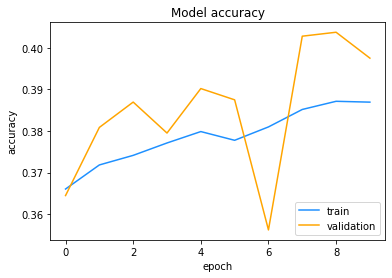

Base 



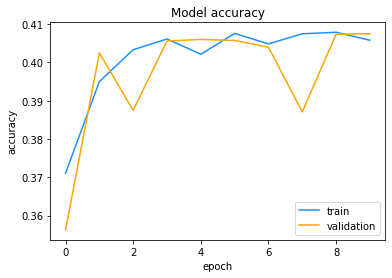

In [ ]:
# Plot accuracy of fitted model
# Using function defined in functions
print('Full data'+ '\n')
plot_accuracy(nn1_train_full)

print('Base '+ '\n')
plot_accuracy(nn1_train_base)

The learning curve for the full dataset shows that the model is underfitting and not finding meaningful relationships in the data, with the validation set still to find a steady 'hill' to descend on.

In the base dataset, it seems to have found a degree of information. The accuracy metric means the model is making the right prediction ~ 41% of the time but cannot give us further information on which classes are being predicted, which requires us to look at the confusion matrix


Increased    17138
Same         16828
Decreased    12242
Name: Indicator, dtype: int64


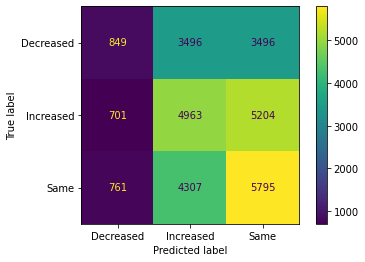

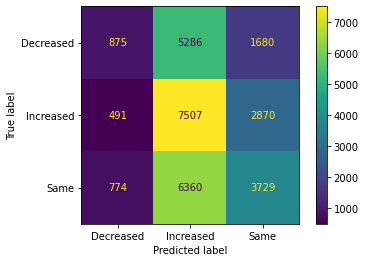

In [ ]:
# Confusion Matrix
# Set labels in accordance to how they were encoded
# in data preparation section
labels = ['Decreased','Increased','Same']

# Print values for full
confusion = confusion_matrix(y_train_full_nn.argmax(axis = 1), preds_train_full_nn1.argmax(axis=1))
confusion_matrix_nn1_full = ConfusionMatrixDisplay(confusion, display_labels = labels)
confusion_matrix_nn1_full.plot(values_format = 'd')

# Print values for base
confusion = confusion_matrix(y_train_base_nn.argmax(axis = 1), preds_train_base_nn1.argmax(axis=1))
confusion_matrix_nn1_base = ConfusionMatrixDisplay(confusion, display_labels = labels)
confusion_matrix_nn1_base.plot(values_format = 'd')

print(df_models['Indicator'].value_counts())

Comparing the initial split of data with our confusion matrix splits, our models are overwhelmingly predicting 'Increased' compared to the other splits in order to increase accuracy. This is moreso true in the second confusion matrix for our base dataset.

In [ ]:
# Classification report
print('Full: '+'\n',classification_report(y_train_full_nn.argmax(axis = 1), preds_train_full_nn1.argmax(axis=1),target_names = labels))
print('Base: '+'\n',classification_report(y_train_base_nn.argmax(axis = 1), preds_train_base_nn1.argmax(axis=1),target_names = labels))

Full: 
               precision    recall  f1-score   support

   Decreased       0.37      0.11      0.17      7841
   Increased       0.39      0.46      0.42     10868
        Same       0.40      0.53      0.46     10863

    accuracy                           0.39     29572
   macro avg       0.39      0.37      0.35     29572
weighted avg       0.39      0.39      0.37     29572

Base: 
               precision    recall  f1-score   support

   Decreased       0.41      0.11      0.18      7841
   Increased       0.39      0.69      0.50     10868
        Same       0.45      0.34      0.39     10863

    accuracy                           0.41     29572
   macro avg       0.42      0.38      0.36     29572
weighted avg       0.42      0.41      0.37     29572



This report calculates the scores from the confusion matrices but overall show the same ideas, that it is performing poorly in classifying 'Decreased' from our tweets data.

### Fit NN2

The final selected Neural network model following iterating through multiple models(See appendix) consists of

 - An input layer of 12 neurons
 - 3 hidden layers with 12 neurons each, a kernel regulariser is added to the last of these which penalises overfitting 
 - An output layer of 3 neurons

 Other parameters that differ from the first neural network are:

  - Optimiser using Adam
  - Model is trained over more epochs

In [ ]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons , reLu activation
model_nn2_full = Sequential()

# Add a first layer with 12 neurons
model_nn2_full.add(Dense(12, input_dim = x_train_full_nn.shape[1], activation = 'relu', kernel_initializer = 'random_uniform'))

# Add hidden layers
model_nn2_full.add(Dense(12, activation = 'relu'))
model_nn2_full.add(Dense(12, activation = 'relu'))
model_nn2_full.add(Dense(12, activation = 'relu', kernel_regularizer = 'l2'))
model_nn2_full.add(Dense(3, activation = 'softmax'))

# Compile the model using the mean-squared error loss function.
model_nn2_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = "adam")

# Train the models.
nn2_train_full = model_nn2_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 25,
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn))

# Obtain the predictions on the training and validation data.
preds_train_full_nn2 = model_nn2_full.predict(x_train_full_nn)
preds_validate_full_nn2 = model_nn2_full.predict(x_validate_full_nn)

Create another model for the base dataset

In [ ]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons , reLu activation
model_nn2_base = Sequential()

# Add a first layer with 12 neurons
model_nn2_base.add(Dense(12, input_dim = x_train_base_nn.shape[1], activation = 'relu', kernel_initializer = 'random_uniform'))

# Add hidden layers
model_nn2_base.add(Dense(12, activation = 'relu'))
model_nn2_base.add(Dense(12, activation = 'relu'))
model_nn2_base.add(Dense(12, activation = 'relu', kernel_regularizer = 'l2'))
model_nn2_base.add(Dense(3, activation = 'softmax'))

# Compile the model using the mean-squared error loss function.
model_nn2_base.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = "adam")

# Train the models.
nn2_train_base = model_nn2_base.fit(x_train_base_nn, y_train_base_nn,
                      epochs = 25, 
                      batch_size = 32,
                      validation_data = (x_validate_base_nn, y_validate_base_nn))

# Obtain the predictions on the training and validation data.
preds_train_base_nn2 = model_nn2_base.predict(x_train_base_nn)
preds_validate_base_nn2 = model_nn2_base.predict(x_validate_base_nn)

### Evaluate NN2

Full data



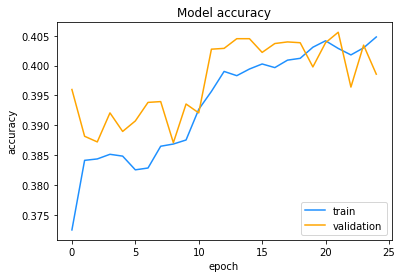

Base data



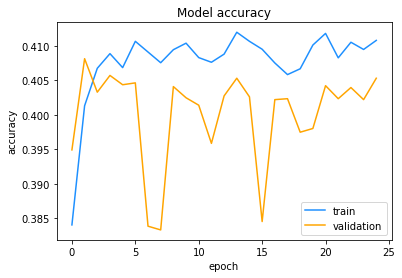

In [ ]:
# Plot accuracy of fitted model
# Using function defined in functions
print('Full data'+ '\n')
plot_accuracy(nn2_train_full)

print('Base data'+ '\n')
plot_accuracy(nn2_train_base)

This neural network performs better for the full dataset, with accuracy in both training and validation datasets improving.  There also appears to be some level of learning happening within the model although an accuracy of ~ 0.4 means it is still unable to predict share price movements reliably.

Decide to go with the full dataset model and perform further evaluation on full only

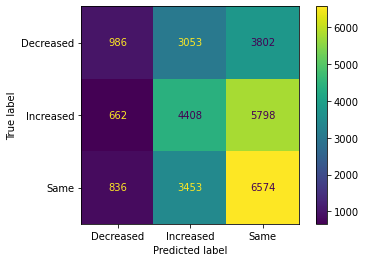

In [ ]:
# Set labels in accordance to how they were encoded
# in data preparation section
labels = ['Decreased','Increased','Same']

# Confusion Matrix

# Print values
confusion = confusion_matrix(y_train_full_nn.argmax(axis = 1), preds_train_full_nn2.argmax(axis=1))
confusion_matrix_nn = ConfusionMatrixDisplay(confusion, display_labels = labels)
confusion_matrix_nn.plot(values_format = 'd')

confusion = confusion_matrix(y_train_full_nn.argmax(axis = 1), preds_train_full_nn2.argmax(axis=1))
confusion_matrix_nn = ConfusionMatrixDisplay(confusion, display_labels = labels)
confusion_matrix_nn.plot(values_format = 'd')


The model is now better at predicting labels, looks to still be underclassifying 'Decreased' labels. 

 - Precision - Within each predicted class, the true label looks to be predicted ~ 40%  of the time which is better than a random guess.

eg. for 'Decreased', 986/(986+662+836) ~ 0.4

In [ ]:
# Classification report
print('Full: '+'\n',classification_report(y_train_full_nn.argmax(axis = 1), preds_train_full_nn2.argmax(axis=1),target_names = labels))

Full: 
               precision    recall  f1-score   support

   Decreased       0.40      0.13      0.19      7841
   Increased       0.40      0.41      0.40     10868
        Same       0.41      0.61      0.49     10863

    accuracy                           0.40     29572
   macro avg       0.40      0.38      0.36     29572
weighted avg       0.40      0.40      0.38     29572



Again, calculating the metrics from the confusion matrix, we confirm what can be seen in the confusion matrix. Model accuracy has improved from 0.38 to 0.4 on the full dataset.

# Tree-based Models

In this section we fit 2 tree-based models that both use ensembling methods, 1 bagging method which will be random forest and 1 boosting method which will be using the XGBoost model.

In each, a simple model will be fitted before parameter testing and finally a grid search is done, passing combinations of parameters to see what provides us with the best model.

Again, the 2 datasets - full features and basic features will be passed through each model


### Prepare the data

Prepare data as we did for Neural networks, however tree based models do not require scaling as no distance measures are calculated 

XGBoost input data is different and a modified function is used

In [ ]:
# Prepare data for random forests as we did for neural network models
# Split Main data into train, validation and test datasets
# Full dataset (all features) 
y_train_full_rf, x_train_full_rf, \
y_validate_full_rf, x_validate_full_rf, \
y_test_full_rf, x_test_full_rf  = create_data_splits(df_models_full, id_col, response_col, split_size = 0.2)

# Base dataset 
y_train_base_rf, x_train_base_rf, \
y_validate_base_rf, x_validate_base_rf, \
y_test_base_rf, x_test_base_rf  = create_data_splits(df_models_base, id_col, response_col, split_size = 0.2)

# Print some output to check that data is prepared properly
# Length of data
print ('Checks on Response variable - ')
print('Data splits: '+'\n')
print('Size of train data: ' + str(len(y_train_full_rf)))
print('Size of validation data: ' + str(len(y_validate_full_rf)))
print('Size of test data: ' + str(len(y_test_full_rf)))

# Encoding
print('\n' + 'First 5 rows as encoded variables: '+ '\n')
print(y_train_full_rf[0:5])

# Features
print('\n'+ 'Check on Features - ')
x_train_full_rf.head(3)

# Scaling not required for Random forest - no distance measures are calculated

Checks on Response variable - 
Data splits: 

Size of train data: 29572
Size of validation data: 7394
Size of test data: 9242

First 5 rows as encoded variables: 

[[0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]]

Check on Features - 


,tweet_likes,tweet_retweets,user_friends,user_followers,user_likes,user_tweets,user_public_lists,Channel_Nine,Channel_Seven,Channel_Ten,label_bert_KMeans_0,label_bert_KMeans_1,label_bert_KMeans_2,label_bert_KMeans_3,label_bert_KMeans_4,label_bert_KMeans_5,label_bert_KMeans_6,label_bert_KMeans_7,label_bert_KMeans_8,label_bert_KMeans_9,label_bert_KMeans_10,label_bert_KMeans_11,retweet_indicator_0,retweet_indicator_1
34977,5,6,2166,414355,13235,175043,1603,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
38565,11,2,17,68947,618,11332,68,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4142,5,1,187,199023,627,182318,1452,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Prepare data for XGB using slightly altered function
# Split Main data into train, validation and test datasets
# Full dataset (all features) 
y_train_full_xgb, x_train_full_xgb, \
y_validate_full_xgb, x_validate_full_xgb, \
y_test_full_xgb, x_test_full_xgb  = create_data_splits_xgb(df_models_full, id_col, response_col, split_size = 0.2)

# Base dataset (less features) 
y_train_base_xgb, x_train_base_xgb, \
y_validate_base_xgb, x_validate_base_xgb, \
y_test_base_xgb, x_test_base_xgb  = create_data_splits_xgb(df_models_base, id_col, response_col, split_size = 0.2)


## Random Forests 

As with Neural network modelling, only selected models will be included in the main section of this notebook whilst tested models will be included in the appendix.

The selected models to be shown are:

 - Random Forest 1 - A basic random forest model with 100 trees 
 - Random Forest 2 - The best performing model off a grid search over a chosen parameter set, considering reasonable values for each parameter
 - As mentioned iterations of other random forest models are included in the appendix
 - XGBoost model - A selected boosting model is shown, only one is shown as it performs well whereas the gridsearch on XGBoost is moved to the appendix

### TB 1 - Random forest

The basic model uses the default parameter sets in the RandomForestClassifier model. 100 trees are fitted and the trees are not limited in the depth they grow to. This invites overfitting but serves as a base before parameters are tested in the appendix. 

In [ ]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1235)

# Build a Random forest model
model_rf1_full = RandomForestClassifier(n_estimators = 100,
                               criterion = 'gini',
                               max_depth = None
                               min_samples_split = 2,
                               random_state = 1234)
# Build the same model for base data
model_rf1_base = RandomForestClassifier(n_estimators = 100,
                               criterion = 'gini',
                               max_depth = None
                               min_samples_split = 2,
                               random_state = 1234)


In [ ]:
# Compile the model
rf1_train_full = model_rf1_full.fit(x_train_full_rf,y_train_full_rf)
rf1_train_base = model_rf1_base.fit(x_train_base_rf,y_train_base_rf)

# Predictions using model
# Full Model
preds_train_full_rf1 = model_rf1_full.predict(x_train_full_rf)
preds_validate_full_rf1 = model_rf1_full.predict(x_validate_full_rf)

# Base Model
preds_train_base_rf1 = model_tb1_base.predict(x_train_base_rf)
preds_validate_base_rf1 = model_tb1_base.predict(x_validate_base_rf)

### Evaluate Random Forest 1

For evaluation we check model accuracy, feature importance, view the confusion matrices and the classification report. The accuracy of the model on the base data is poor and focus evaluation on the full dataset.

In [ ]:
# Accuracy
print('Full Data')
print('Training Accuracy: ', accuracy_score(y_train_full_rf, preds_train_full_rf1))
print('Validation Accuracy: ', accuracy_score(y_validate_full_rf, preds_validate_full_rf1))

print('\n'+ 'Base Data')
print('Training Accuracy: ', accuracy_score(y_train_base_rf, preds_train_base_rf1))
print('Validation Accuracy: ', accuracy_score(y_validate_base_rf, preds_validate_base_rf1))

Full Data
Training Accuracy:  0.648214527255512
Validation Accuracy:  0.2825263727346497

Base Data
Training Accuracy:  0.3944271608278101
Validation Accuracy:  0.1919123613740871


Accuracy scores for random forest model 1 indicate a high level of overfitting for both the full dataset and the base dataset. 

The full dataset which included more features allowed the model to overfit for training data with an accuracy of 0.65 but both validation datasets performed poorly in this initial basic random forest model. Given the poor performance in the Base data, we focus the rest of the evaluation on the full dataset


Plot feature importance to understand what the model is picking up

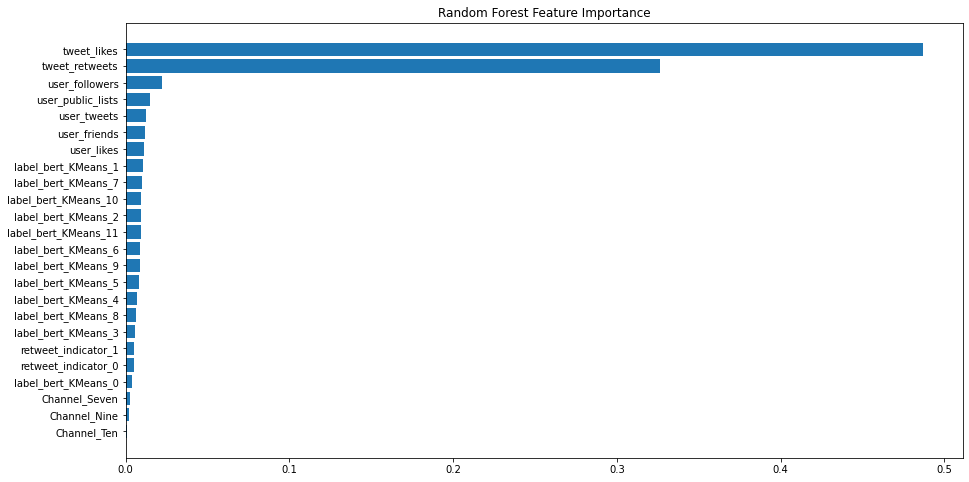

In [ ]:
# Plot feature importance

# Get feature names and feature importances
sorted_idx = rf1_train_full.feature_importances_.argsort()
feature_cols = pd.array([i for i in df_models_full.columns if i not in id_col + response_col])
plt.barh(feature_cols[sorted_idx],tb1_train_full.feature_importances_[sorted_idx])

# Formatting
plt.title("Random Forest Feature Importance")
fig = plt.gcf()
fig.set_size_inches(15, 8)

The important features the random forest model has picked up are metrics related to the tweets themselves i.e the tweets and users. 

Confusion Matrices - Full data and Base data

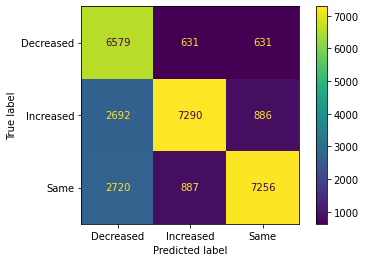

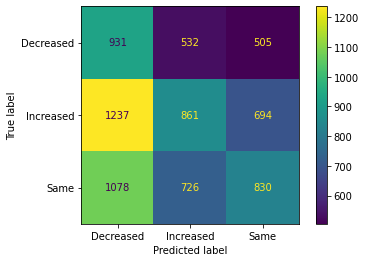

In [ ]:
# Set labels in accordance to how they were encoded
# in data preparation section
labels = ['Decreased','Increased','Same']

# Confusion Matrix Full data
# Training
confusion_full_train = confusion_matrix(y_train_full_tb.argmax(axis = 1), preds_train_full_tb1.argmax(axis=1))
confusion_matrix_tb_train = ConfusionMatrixDisplay(confusion_full_train, display_labels= labels)
confusion_matrix_tb_train.plot(values_format = 'd')

# Validation
confusion_full_validate = confusion_matrix(y_validate_full_tb.argmax(axis = 1), preds_validate_full_tb1.argmax(axis=1))
confusion_matrix_tb_validate = ConfusionMatrixDisplay(confusion_full_validate, display_labels= labels)
confusion_matrix_tb_validate.plot(values_format = 'd')

Overfitting of the data is apparent in the confusion matrices as the first matrix on training data has performed quite well across the diagonal, whilst not so on the validation set.

The validation set is overpredicting values in the 'Decreased' bucket in contrast to the neural network models.

Classification Report

In [ ]:
# Classification report
print('Training: '+'\n',classification_report(y_train_full_rf, preds_train_full_rf1,target_names = labels))
print('Validation: '+'\n',classification_report(y_validate_full_rf, preds_validate_full_rf1,target_names = labels))

Training: 
               precision    recall  f1-score   support

   Decreased       0.86      0.59      0.70      7841
   Increased       0.83      0.67      0.74     10868
        Same       0.83      0.67      0.74     10863

   micro avg       0.83      0.65      0.73     29572
   macro avg       0.84      0.64      0.73     29572
weighted avg       0.84      0.65      0.73     29572
 samples avg       0.65      0.65      0.65     29572

Validation: 
               precision    recall  f1-score   support

   Decreased       0.31      0.20      0.24      1968
   Increased       0.41      0.31      0.35      2792
        Same       0.41      0.32      0.36      2634

   micro avg       0.38      0.28      0.33      7394
   macro avg       0.38      0.28      0.32      7394
weighted avg       0.38      0.28      0.32      7394
 samples avg       0.28      0.28      0.28      7394



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification report confirms what has been shown in previous evaluation methods, overpredicting 'Decreased' labels and that overfitting is an issue.

### Random Forest 2 - GridSearch 

Following parameter testing (see Appendix), we set up a grid search to find a best performing set out of a given parameter set.

The chosen parameter set is chosen as:

 - n_estimators - The number of trees starting at 20 going to 160, divided into 5 intervals, more trees can reduce overfitting but will take longer to run, 
 - max_depth -  Chosen between 5 to 30, choosing deeper trees will result in overfitting, whilst not using enough depth will result in underfitting.
 - max_features - Consider the number of features the tree looks at when splitting, None considers all features whereas 'auto' means it will limit the number of features to the square root of the number of features
 - min_samples_split - Number of minimum samples within each split. 2, 5 and 10 are reasonable values and anymore might mean the model could underfit
 - min_samples_leaf - Number of minimum samples at each node. Chosen to be 1,2 and 4, as with above, do not want the minimum samples to be too high.

In [ ]:
## Define parameter ranges
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 160, num = 3)]
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
max_features = ['auto', None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}
           
model = GridSearchCV(RandomForestClassifier(), rf_grid, scoring = 'accuracy', cv = 3, verbose = 3)

# Fit the model
model.fit(x_train_full_rf,y_train_full_rf)

In [ ]:
# Return the best parameters out of the grid search
model.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 160}

In [ ]:
# Create Model using best parameters
model_rf2_full = RandomForestClassifier(max_depth= 30,
                                        max_features = 'auto',
                                        min_samples_leaf = 1,
                                        min_samples_split = 2,
                                        n_estimators = 160,
                                        random_state = 1234)
# Compile the model
model_rf2_full.fit(x_train_full_rf,y_train_full_rf)

# Generate predictions
preds_train_full_rf2 = model_rf2_full.predict(x_train_full_rf)
preds_validate_full_rf2 = model_rf2_full.predict(x_validate_full_rf)

### Evaluate Random Forest 2  - grid search

Perform evaluation as we did for Random Forest 1

In [ ]:
# Accuracy
print('Full Data')
print('Training Accuracy: ', accuracy_score(y_train_full_rf, preds_train_full_rf2))
print('Validation Accuracy: ', accuracy_score(y_validate_full_rf, preds_validate_full_rf2))

Full Data
Training Accuracy:  0.6386446638712295
Validation Accuracy:  0.2761698674601028


Overfitting has not been resolved after doing a gridsearch and testing multiple parameters.

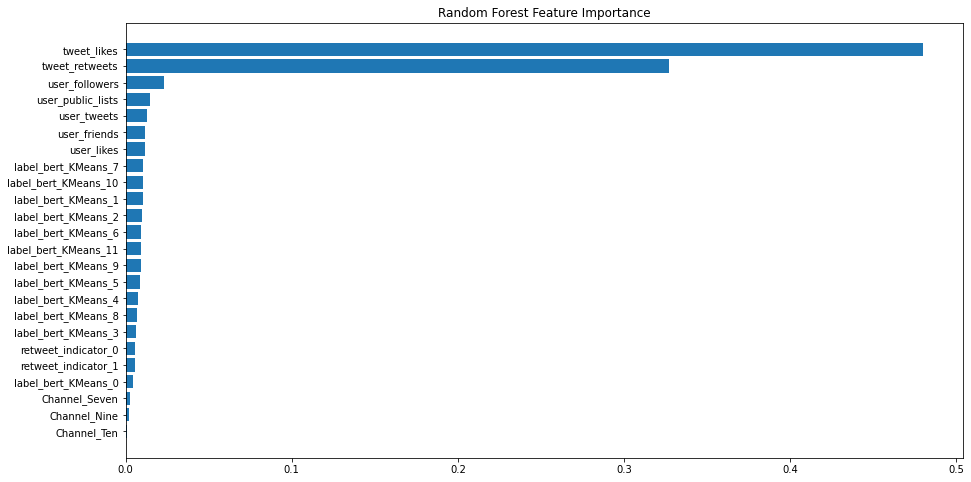

In [ ]:
# Plot feature importance
# Get feature names and feature importances
sorted_idx = model_rf2_full.feature_importances_.argsort()
feature_cols = pd.array([i for i in df_models_full.columns if i not in id_col + response_col])
plt.barh(feature_cols[sorted_idx],model_rf2_full.feature_importances_[sorted_idx])

# Formatting
plt.title("Random Forest Feature Importance")
fig = plt.gcf()
fig.set_size_inches(15, 8)

The results are similar to Random Forest 1 in feature importance

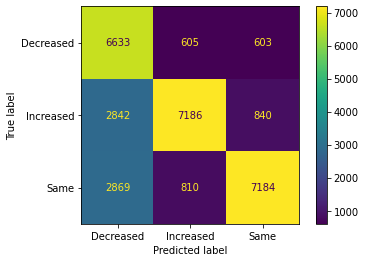

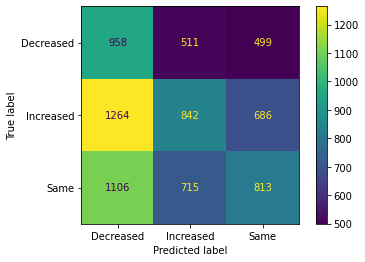

In [ ]:
# Confusion Matrix Full data
# Training
confusion_full_train = confusion_matrix(y_train_full_rf.argmax(axis=1), preds_train_full_rf2.argmax(axis=1))
confusion_matrix_rf_train = ConfusionMatrixDisplay(confusion_full_train, display_labels= labels)
confusion_matrix_rf_train.plot(values_format = 'd')

# Validation
confusion_full_validate = confusion_matrix(y_validate_full_rf.argmax(axis=1), preds_validate_full_rf2.argmax(axis=1))
confusion_matrix_rf_validate = ConfusionMatrixDisplay(confusion_full_validate, display_labels= labels)
confusion_matrix_rf_validate.plot(values_format = 'd')

Again, even testing for different split, leaf and depth parameters, the model is overfitting to the training data. It is also heavily predicting 'Decreased' labels as it did for RF1

In [ ]:
# Classification report
print('Training: '+'\n',classification_report(y_train_full_rf, preds_train_full_rf2,target_names = labels))
print('Validation: '+'\n',classification_report(y_validate_full_rf, preds_validate_full_rf2,target_names = labels))

# Accuracy scores RF1 vs RF2
print('Accuracy RF1: '+'\n',accuracy_score(y_validate_full_rf, preds_validate_full_rf1))
print('Accuracy RF2: '+'\n',accuracy_score(y_validate_full_rf, preds_validate_full_rf2))

Training: 
               precision    recall  f1-score   support

   Decreased       0.87      0.58      0.69      7841
   Increased       0.84      0.66      0.74     10868
        Same       0.83      0.66      0.74     10863

   micro avg       0.84      0.64      0.73     29572
   macro avg       0.85      0.63      0.72     29572
weighted avg       0.84      0.64      0.73     29572
 samples avg       0.64      0.64      0.64     29572

Validation: 
               precision    recall  f1-score   support

   Decreased       0.32      0.20      0.24      1968
   Increased       0.41      0.30      0.35      2792
        Same       0.41      0.31      0.35      2634

   micro avg       0.39      0.28      0.32      7394
   macro avg       0.38      0.27      0.31      7394
weighted avg       0.38      0.28      0.32      7394
 samples avg       0.28      0.28      0.28      7394

Accuracy RF1: 
 0.2825263727346497
Accuracy RF2: 
 0.2761698674601028


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy of the grid-searched model performs slightly worse than the base model and this is likely due to limiting the depth of the trees. Regardless the random forests models are overfitted and an alternative tree-based model XGBoost is considered

##XGBoost

Next we consider a popular boosting algorithm XGBoost. It boosts through gradient boosting where trees are grown in sequentially which converts weak learners into strong learners by adding weights to the weak learners and reduce weights of the strong learners. 

It also regularises learning weights to avoid overfitting which was an issue in the random forest models above.





### TB 2 - XGboost

Set parameters as :
 - Objective - Multi softmax to suit our multi-class classification task
 - n_estimators - 600 trees
 - Learning rate - 0.01 a lower learning rate reduces the likelihood of overfitting
 - max_depth 6 - Similar reasoning to Random forests, want to limit this as much as possible

In [ ]:
# XGboost
# Set up model
model_xgb1_full = XGBClassifier(booster = 'gbtree',
                                learning_rate=0.01, 
                                max_depth = 6,
                                n_estimators=600,
                                objective = 'multi:softmax',
                                verbosity = 0)

# Compile the model
# y input converted into 1d array
model_xgb1_full.fit(x_train_full_xgb, y_train_full_xgb.values.ravel())

# Generate predictions
preds_train_full_xgb1 = model_xgb1_full.predict(x_train_full_xgb)
preds_validate_full_xgb1 = model_xgb1_full.predict(x_validate_full_xgb)


### Evaluate XGBoost

Print accuracy

In [ ]:
# Accuracy
print('Full Data')
print('Training Accuracy: ', accuracy_score(y_train_full_xgb, preds_train_full_xgb1))
print('Validation Accuracy: ', accuracy_score(y_validate_full_xgb, preds_validate_full_xgb1))

Full Data
Training Accuracy:  0.46686054375760855
Validation Accuracy:  0.4129023532593995


Higher accuracy on training shows some level of overfitting, however accuracy on validation set is the best of all models fitted as yet.

Plot feature importance

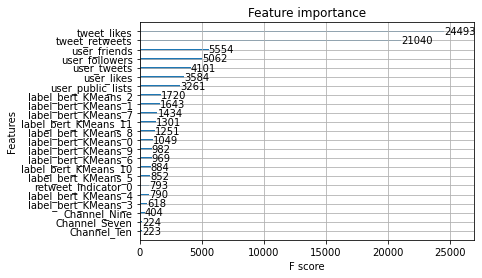

In [ ]:
from xgboost import plot_importance
plot_importance(model_xgb1_full)

The features picked up are similar to the random forest models. However the improvement in performance means that the weights given to each fit better to the validation set

Plot confusion matrices

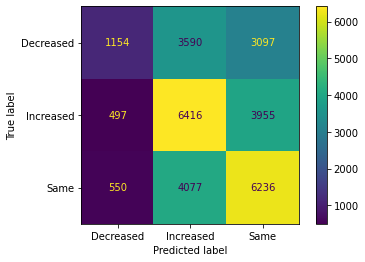

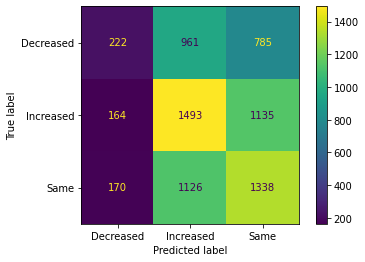

In [ ]:
# Confusion Matrix Full data
# Training
confusion_full_train = confusion_matrix(y_train_full_xgb, preds_train_full_xgb1)
confusion_matrix_xgb_train = ConfusionMatrixDisplay(confusion_full_train, display_labels= labels)
confusion_matrix_xgb_train.plot(values_format = 'd')

# Validation
confusion_full_validate = confusion_matrix(y_validate_full_xgb, preds_validate_full_xgb1)
confusion_matrix_xgb_validate = ConfusionMatrixDisplay(confusion_full_validate, display_labels= labels)
confusion_matrix_xgb_validate.plot(values_format = 'd')

Performance on the training data set has fallen from 0.67 to 0.47 and this is visible in the first confusion matrix. 

performance on the validation set has significantly improve and overfitting is less of an issue. 

In [ ]:
# Classification report
print('Training: '+'\n',classification_report(y_train_full_xgb, preds_train_full_xgb1,target_names = labels))
print('Validation: '+'\n',classification_report(y_validate_full_xgb, preds_validate_full_xgb1,target_names = labels))

Training: 
               precision    recall  f1-score   support

   Decreased       0.52      0.15      0.23      7841
   Increased       0.46      0.59      0.51     10868
        Same       0.47      0.57      0.52     10863

    accuracy                           0.47     29572
   macro avg       0.48      0.44      0.42     29572
weighted avg       0.48      0.47      0.44     29572

Validation: 
               precision    recall  f1-score   support

   Decreased       0.40      0.11      0.18      1968
   Increased       0.42      0.53      0.47      2792
        Same       0.41      0.51      0.45      2634

    accuracy                           0.41      7394
   macro avg       0.41      0.39      0.37      7394
weighted avg       0.41      0.41      0.39      7394



Again this report puts numbers to the confusion matrix set above. As with other models, low f1 score on 'Decreased' label

# Evaluate selected models

Tthe two selected models are NN2 for Neural Networks and XGB for tree based models. Both are on the full dataset due to models inability to learn from the base dataset. 

Evaluation has been run on these models on training and validation sets and this section will repeat most of that, but be run on test data before running the evaluation and comparing the two. 

Predictions on test data

In [ ]:
# Obtain the predictions on the training and validation data.
preds_test_full_nn2 = model_nn2_full.predict(x_test_full_nn)
preds_test_full_xgb1 = model_xgb1_full.predict(x_test_full_xgb)

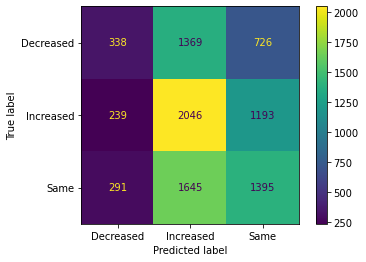

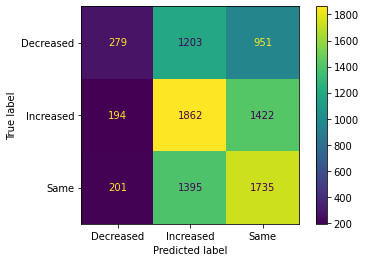

In [ ]:
# Confusion Matrix Full data
# Neural network
confusion_full_test_nn = confusion_matrix(y_test_full_nn.argmax(axis = 1), preds_test_full_nn2.argmax(axis = 1))
confusion_matrix_nn_test = ConfusionMatrixDisplay(confusion_full_test_nn, display_labels= labels)
confusion_matrix_nn_test.plot(values_format = 'd')

# XGB
confusion_full_test_xgb = confusion_matrix(y_test_full_xgb, preds_test_full_xgb1)
confusion_matrix_xgb_test = ConfusionMatrixDisplay(confusion_full_test_xgb, display_labels= labels)
confusion_matrix_xgb_test.plot(values_format = 'd')

Select measures of success

In [ ]:
# Accuracy
print('NN Accuracy: ', accuracy_score(y_test_full_nn.argmax(axis = 1), preds_test_full_nn2.argmax(axis = 1)))
print('XGB Accuracy: ', accuracy_score(y_test_full_xgb, preds_test_full_xgb1))

print('\n')
# f1 score
print('NN f1{Decreased, Increased, Same}: ', f1_score(y_test_full_nn.argmax(axis = 1), preds_test_full_nn2.argmax(axis = 1), average = None))
print('XGB f1{Decreased, Increased, Same}: ', f1_score(y_test_full_xgb, preds_test_full_xgb1, average = None))

print('\n')
# Recall
print('NN Recall {Decreased, Increased, Same}: ', recall_score(y_test_full_nn.argmax(axis = 1), preds_test_full_nn2.argmax(axis = 1), average = None))
print('XGB Recall {Decreased, Increased, Same}: ', recall_score(y_test_full_xgb, preds_test_full_xgb1, average = None))

print('\n')
# Precision
print('NN Precision {Decreased, Increased, Same}: ', precision_score(y_test_full_nn.argmax(axis = 1), preds_test_full_nn2.argmax(axis = 1), average = None))
print('XGB Precision {Decreased, Increased, Same}: ', precision_score(y_test_full_xgb, preds_test_full_xgb1, average = None))

NN Accuracy:  0.4088941787491885
XGB Accuracy:  0.4193897424799827


NN f1{Decreased, Increased, Same}:  [0.20478643 0.47926915 0.41986456]
XGB f1{Decreased, Increased, Same}:  [0.17959446 0.4691358  0.46646055]


NN Recall {Decreased, Increased, Same}:  [0.13892314 0.58826912 0.41879316]
XGB Recall {Decreased, Increased, Same}:  [0.11467324 0.53536515 0.52086461]


NN Precision {Decreased, Increased, Same}:  [0.38940092 0.40434783 0.42094146]
XGB Precision {Decreased, Increased, Same}:  [0.41394659 0.41748879 0.42234664]


The accuracy scores for the two models are relatively similar, with the XGB model slightly outperforming the Neural network model. Accuracy in our context refers to the proportion of times the model will predict the share price movement correct based on tweet data. This is a relatively low prediction rate.


The f1 scores for 'Decreased' in both models are poor, with the XGB model doing worse at 0.18. F1 combines both precision and recall and the model the poor performance is due to the recall score - i.e it is not predicting 'Decreased' when an actual decrease in share price happens. Precision, the proportion of actual 'Decrease' when the model predicts a 'Decrease' is not affected

The implications of this in our context is that the model will perform poorly in circumstances where the market is going through a downturn or NEC share price is dropping, it will fail to predict decreases in the share price of NEC and poor investment decisions will be made off it.

Apart from that the overall model accuracy is low and the relationship between the tweets and NEC share prices is not as strong as originally thought.

In [ ]:
# Classification report
print('Training: '+'\n',classification_report(y_test_full_xgb, preds_test_full_xgb1,target_names = labels))

Training: 
               precision    recall  f1-score   support

   Decreased       0.41      0.11      0.18      2433
   Increased       0.42      0.54      0.47      3478
        Same       0.42      0.52      0.47      3331

    accuracy                           0.42      9242
   macro avg       0.42      0.39      0.37      9242
weighted avg       0.42      0.42      0.39      9242



# Appendix 

Store our test models here which were not chosen in the main notebook

This section is mainly for parameter testing and doing iterations of the models to see the impact of changing parameters in order to find a suitable model 

## Neural Network Models


To be compared to base model accuracy of :
 - Train: 0.3869
 - Validation: 0.3975


Iteration 1: Increasing complexity

Increasing Input neurons, adding a hidden layer 15 neurons

Full data



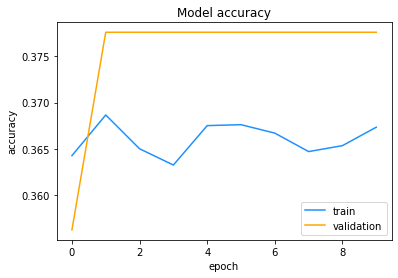

In [ ]:
# Build Neural network for Full dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_full = Sequential()

# Add a first layer 
model_nn1_full.add(Dense(units = 12, 
                input_dim = x_train_full_nn.shape[1], 
                activation = 'relu'
                ))
# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'relu',
                kernel_initializer = 'random_uniform'))


# Add a hidden layer 
model_nn1_full.add(Dense(units = 15, 
                activation = 'relu',
                kernel_initializer = 'random_uniform'))

# Add an output layer  
model_nn1_full.add(Dense(units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'))

# Compile the model using Categorical cross entropy.
model_nn1_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.SGD(learning_rate=0.2))

# Train the models.
nn1_train_full = model_nn1_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 10, 
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn), verbose = 0)

# Make predictions on the training and validation data.
preds_train_full_nn1 = model_nn1_full.predict(x_train_full_nn)
preds_validate_full_nn1 = model_nn1_full.predict(x_validate_full_nn)

# Plot accuracy of fitted model
# Using function defined in functions
plot_accuracy(nn1_train_full)
accuracy_score(nn1_train_full)

Iteration 2: From Iteration 1 , accuracy did not improve from a more complex model, Scale back number of neurons, trying different activation functions - tanh and sigmoid activations in hidden layers,
increasing epochs for better training

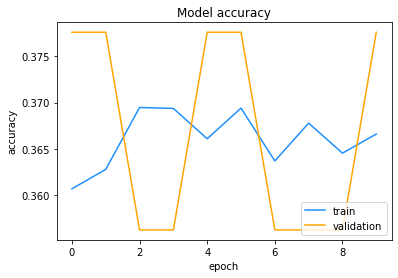

In [ ]:
# Build Neural network for Full dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_full = Sequential()

# Add a first layer 
model_nn1_full.add(Dense(units = 4, 
                input_dim = x_train_full_nn.shape[1], 
                activation = 'relu'
                ))
# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'sigmoid',
                kernel_initializer = 'random_uniform'))


# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'tanh',
                kernel_initializer = 'random_uniform'))

# Add an output layer  
model_nn1_full.add(Dense(units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'))

# Compile the model using Categorical cross entropy.
model_nn1_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.SGD(learning_rate=0.2))

# Train the models.
nn1_train_full = model_nn1_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 10, 
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn), verbose = 0)

# Make predictions on the training and validation data.
preds_train_full_nn1 = model_nn1_full.predict(x_train_full_nn)
preds_validate_full_nn1 = model_nn1_full.predict(x_validate_full_nn)

# Plot accuracy of fitted model
# Using function defined in functions
plot_accuracy(nn1_train_full)

Iteration 3: Add a regulariser that regularises the weights, reduce learning rate to improve learning, increase epochs to 30



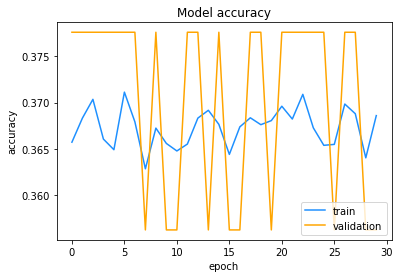

In [ ]:
# Build Neural network for Full dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_full = Sequential()

# Add a first layer 
model_nn1_full.add(Dense(units = 4, 
                input_dim = x_train_full_nn.shape[1], 
                activation = 'relu'
                ))
# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'sigmoid'))


# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'tanh',
                kernel_regularizer = 'l2'))

# Add an output layer  
model_nn1_full.add(Dense(units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'
          ))

# Compile the model using Categorical cross entropy.
model_nn1_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = keras.optimizers.SGD(learning_rate=0.1))

# Train the models.
nn1_train_full = model_nn1_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 30, 
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn), verbose = 0)

# Make predictions on the training and validation data.
preds_train_full_nn1 = model_nn1_full.predict(x_train_full_nn)
preds_validate_full_nn1 = model_nn1_full.predict(x_validate_full_nn)

# Plot accuracy of fitted model
# Using function defined in functions
plot_accuracy(nn1_train_full)

Iteration 4 - Adam optimiser

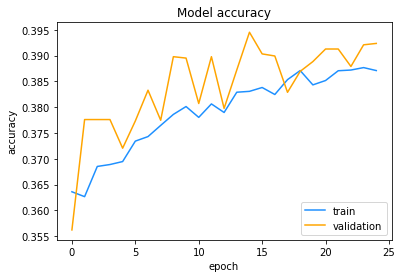

In [ ]:
# Build Neural network for Full dataset
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1234)

# Build a sequential model with 1 hidden layer, 4 neurons 
model_nn1_full = Sequential()

# Add a first layer 
model_nn1_full.add(Dense(units = 4, 
                input_dim = x_train_full_nn.shape[1], 
                activation = 'relu'
                ))
# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'sigmoid'))


# Add a hidden layer 
model_nn1_full.add(Dense(units = 12, 
                activation = 'tanh',
                kernel_regularizer = 'l2'))

# Add an output layer  
model_nn1_full.add(Dense(units = 3,
          activation = 'softmax',                                        
          kernel_initializer = 'random_uniform'
          ))

# Compile the model using Categorical cross entropy.
model_nn1_full.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = 'adam')

# Train the models.
nn1_train_full = model_nn1_full.fit(x_train_full_nn, y_train_full_nn,
                      epochs = 25, 
                      batch_size = 32,
                      validation_data = (x_validate_full_nn, y_validate_full_nn), verbose = 0)

# Make predictions on the training and validation data.
preds_train_full_nn1 = model_nn1_full.predict(x_train_full_nn)
preds_validate_full_nn1 = model_nn1_full.predict(x_validate_full_nn)

# Plot accuracy of fitted model
# Using function defined in functions
plot_accuracy(nn1_train_full)

Adam optimiser uses an adaptive learning rate and the model improves significantly after using it. 

From here we tune the other parameters to settle on NN2.

## Random forest Models

Benchmark to compared against RF1:

Training Accuracy:  0.648

Validation Accuracy:  0.283

Iteration 1 - 
 - limit max depth from None to 20, 
 - and increase min_samples_split from 2 to 5 
  
 Both with objective of reducing the overfitting, 

In [ ]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1235)

# Build a Random forest model
model_rf1_full = RandomForestClassifier(n_estimators = 100,
                               criterion = 'gini',
                               max_depth = 20,
                               min_samples_split = 5,
                               random_state = 1234)

# Compile the model
rf1_train_full = model_rf1_full.fit(x_train_full_rf,y_train_full_rf)

# Predictions using model
# Full Model
preds_train_full_rf1 = model_rf1_full.predict(x_train_full_rf)
preds_validate_full_rf1 = model_rf1_full.predict(x_validate_full_rf)

# Accuracy scores
print('Training Accuracy: ', accuracy_score(y_train_full_rf, preds_train_full_rf1))
print('Validation Accuracy: ', accuracy_score(y_validate_full_rf, preds_validate_full_rf1))


Training Accuracy:  0.38063032598403895
Validation Accuracy:  0.17838788206654044


Reduced Training accuracy to something more in line with output from neural network. Validation accuracy has been reduced too. The model is performing similarly to neural network on the training data set but overfitting is present from based off poor validation accuracy.

Iteration 2 - Adjust a few more parameters but judging off performance, a grid search will be needed.

 - max_features set to None to allow for consideration of all features during splitting
 - Increase number of trees used to 200 in case 100 was too low


In [ ]:
# Set the seed for the random number generator, for reproducibility of the results.
np.random.seed(1235)

# Build a Random forest model
model_rf1_full = RandomForestClassifier(n_estimators = 200,
                               criterion = 'gini',
                               max_depth = 20,
                               max_features = None,
                               min_samples_split = 5,
                               random_state = 1234)

# Compile the model
rf1_train_full = model_rf1_full.fit(x_train_full_rf,y_train_full_rf)

# Predictions using model
# Full Model
preds_train_full_rf1 = model_rf1_full.predict(x_train_full_rf)
preds_validate_full_rf1 = model_rf1_full.predict(x_validate_full_rf)

# Accuracy scores
print('Training Accuracy: ', accuracy_score(y_train_full_rf, preds_train_full_rf1))
print('Validation Accuracy: ', accuracy_score(y_validate_full_rf, preds_validate_full_rf1))

Training Accuracy:  0.43571621804409577
Validation Accuracy:  0.17622396537733298


Training accuracy 

##XGBoost Grid Search

Given the performance of the first XGBoost model, instead of iterating parameters, we do a gridsearch to see if much improvement can be gained.

Benchmark accuracy scores are:

Training Accuracy:  0.467
Validation Accuracy:  0.413

In [ ]:
## Define parameter ranges

# A parameter grid for XGBoost
xgb_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'objective': ['multi:softmax']
        }
model_xgb2_full = GridSearchCV(XGBClassifier(), xgb_grid, scoring = 'accuracy', cv = 3, verbose = 2)

# fit the model
model_xgb2_full.fit(x_train_full_xgb, y_train_full_xgb)

model_xgb2_full.best_params_

# Create a model with best parameters

model_xgb1_full2 = XGBClassifier(colsample_bytree=0.6, 
                      gamma = 1.5,
                      max_depth = 5,
                      objective = 'multi:softmax',
                      subsample = 0.8,
                      mid_child_weight = 1))

# Compile the model
model_xgb1_full2.fit(x_train_full_xgb, y_train_full_xgb)

# Generate predictions
preds_train_full_xgb2 = model_xgb1_full2.predict(x_train_full_xgb)
preds_validate_full_xgb2 = model_xgb1_full2.predict(x_validate_full_xgb)

# Accuracy
print('Full Data')
print('Training Accuracy: ', accuracy_score(y_train_full_xgb, preds_train_full_xgb2))
print('Validation Accuracy: ', accuracy_score(y_validate_full_xgb, preds_validate_full_xgb2))

Full Data
Training Accuracy:  0.45458541863925334
Validation Accuracy:  0.4115499053286448
